**Description:**

This is the Jupyter notebook for the second project during the data science bootcamp at neue fische.

**Project Name:** Lending Club

**Team:** Silas Mederer, Jonas Bechthold

**Date:** 2020-10-02 to 2020-10-08

# Setting up & load data

In [70]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import math


# visualization
import seaborn as sns
sns.set(style="white")   
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# warnings handler
import warnings
warnings.filterwarnings("ignore")

# data to get an idea about what data we are looking at
df = pd.read_csv("data/loans_2007.csv")

In [71]:
random_state = 100           # Ensures modeling results can be replicated
test_size = 0.3              # Train/test split
#n_reduced = 10000            # Number of row items in reduced dataset (modeling)
#scoring = "f1"               # modeling scoring options: "f1", "recall", "precision", "accuracy", "roc_auc"

pd.set_option('display.max_columns', 50) # Sets maximum columns displayed in tables

# Business Understanding 

## General

For this project we chose a dataset from Lending Club approved personal loans between 2007 and 2011. The data can be found on www.lendingclub.com. The purpose of the analysis is to: 

**- reduce defaults**

**- improve profitability** 

**- and help the company and investors to determine interest rates.**

We will use machine learning models to analyze credit risk (paid back vs. not paid back (default)) as a binary classification problem.

Tasks:

- Make a model to assess whether or not a new customer is likely to pay back the loan. You can use several different machine learning models.

- In the accepted loans data, we have a column called "grade." It takes values from A-G (A is the best, G is the worst). The task is to build a classifier that, given some other features, can accurately categorize a loan by grade.



## Background - Peer to Peer Lending (P2P)


Since LendingClub is a Peer to Peer Credit (P2P) platform, lets have a look on wikipedia to what P2P lending is about:

"Peer-to-peer lending, also abbreviated as P2P lending, is the practice of lending money to individuals or businesses through online services that match lenders with borrowers. Peer-to-peer lending companies often offer their services online, and attempt to operate with lower overhead and provide their services more cheaply than traditional financial institutions.
As a result, lenders can earn **higher returns** compared to savings and investment products offered by banks, while borrowers can **borrow money at lower interest rates**, even after the P2P lending company has taken a fee for providing the match-making platform and credit checking the borrower. There is the risk of the borrower defaulting on the loans taken out from peer-lending websites."

from: https://en.wikipedia.org/wiki/Peer-to-peer_lending

We can see that since the credits are not regulated by banks, for both in investors and the platform it is crucial to **avoid a large number of default loans** and also to compensate investors for high risk loans by using higher interest rates.

Two things we can look at our dataset:
    
- higher returns: What is the average interest rate for credits on P2P lending?
- borrow money at lower interest rates: Is the interest rate for P2P lending actually smaller than for bank credits?

## Background - LendingClub.com

For this project we will be exploring publicly available data from LendingClub.com. Lending Club connects people who need money (borrowers) with people who have money (investors) through a digital platform. 

Now since we know what P2P lending is about, let's see what we can find out about LendingClub.com.

"LendingClub is an American peer-to-peer lending company, headquartered in San Francisco, California. It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a **secondary market**. LendingClub is the world's largest peer-to-peer lending platform. The company claims that $15.98 billion in loans had been originated through its platform up to December 31, 2015.

LendingClub enables borrowers to create **unsecured personal loans** between **1,000 and 40,000** dollar. The standard loan period is **three years**. Investors can search and browse the loan listings on LendingClub website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. LendingClub makes money by charging borrowers an origination fee and investors a service fee.

LendingClub also makes traditional direct to consumer loans, including automobile refinance transactions, through WebBank, an FDIC-insured, state-chartered industrial bank that is headquartered in Salt Lake City Utah. The loans are not funded by investors but are assigned to other financial institutions.

The company raised $1 billion in what became the largest technology IPO of 2014 in the United States. Though viewed as a pioneer in the fintech industry and one of the largest such firms, LendingClub experienced problems in early 2016, with difficulties in **attracting investors**, a scandal over some of the firm's loans and concerns by the board over CEO Renaud Laplanche's disclosures leading to a large drop in its share price and Laplanche's resignation."

from: https://en.wikipedia.org/wiki/LendingClub

The concept sounds interesting. Some facts we should keep in mind during the project:

- secondary market available: Check if the loans we are looking at are resaled or do we only look on the primary market?

- the loan amount is between 1000 and 40000 dollars: This gives us the range of credit size:

- standard loan period is 3 years or 36 months

- for the platform it is really important to attract investors: What are the consequences for that on our project target: We want enough investors so we have to provide a sufficient number of (non default) credits and we want the investors to be satisfied (e.g. the dont want to loose money) and they want a high interest rate, since they are investing in non secured assests. 

## Key Questions for our project

1. How to indentify default credits?
    - What do we consider as a credit "default": Compelet default? Late payments? Successfull recovery? 
    - Do we have fully paid credits? What are the main characteristics of these credits?
    - What are the characteristics of a default credit?
 
 
2. How to set up interest rates?
    - Are all credits with high interest rates associated with a high risk?
    - What is a high interest rate? 
    - How are credits defaults related to the interest rate?


3. How to improve profitability of lending club?
    - Avoid defaults to have satisfied customers?
    - Recovery of credits costs also money, so how we can avoid this? 
    - Profit for lending clubs are the fees for both investor and lender: We want to maximize the number of credits which are non defaults!


4. How to choose the performance metrics for our machine learning model?
    - This really depends on the target we are looking at. 
    - If we want to protect the investors from loosing money, we want to avoid default credits (e.g. we dont have to identify all possible non default credits, we only want to avoid the defaults). 
    - If we want to maximize the profit for LendingClub, we also have to minimize the number of incorrectly identified credits as defaults which would actually pay back the full amount.

**Bonus:** 

- What are fair credits? - The credits for people who can not get a credit at a private bank, but how fair is that for the borrower in terms of interest rates? 

- Based on a scenario: Could P2P have a high interest in providing social credits for people without the possibility of getting a credit at a bank - would it be possible to accept less return for that.

## Dataset Description

We first have a look what is inside out dataset and what are the features we have inside.

In [72]:
df.shape

(42538, 52)

We can see that we have about 43000 datapoints and a huge amount of columns (52).

### Column Descriptions

Let's get an idea about the columns and find out what they mean:

In [73]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

Some of the descriptions are quite cryptical, so we use the official description from (https://www.lendingclub.com/developers/listed-loans) and get all the columns we get here in a table.

### Feature glossary & label for our dataset


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>LoanStatNew</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
      <tr>
      <th>0</th>
      <td>id</td>
      <td>A unique LC assigned ID for the loan listing.</td>
    </tr>
      <tr>
      <th>1</th>
      <td>member_id</td>
      <td>A unique LC assigned Id for the borrower member.</td>
    </tr>
    <tr>
      <th>2</th>
      <td>loan_amnt</td>
      <td>The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.</td>
    </tr>
      <tr>
      <th>3</th>
      <td>funded_amnt</td>
      <td>The total amount funded by investors for that loan at that point in time.</td>
    </tr>   
      <tr>
      <th>4</th>
      <td>funded_amnt_inv</td>
      <td>The total amount funded by investors for that loan at that point in time.</td>
    </tr> 
    <tr>
      <th>5</th>
      <td>term</td>
      <td>The number of payments on the loan. Values are in months and can be either 36 or 60.</td>
    </tr>
    <tr>
      <th>6</th>
      <td>int_rate</td>
      <td>Interest Rate on the loan.</td>
    </tr>
    <tr>
      <th>7</th>
      <td>installment</td>
      <td>The monthly payment owed by the borrower if the loan originates.</td>
    </tr>
    <tr>
      <th>8</th>
      <td>grade</td>
      <td>LC assigned loan grade</td>
    </tr>
    <tr>
      <th>9</th>
      <td>sub_grade</td>
      <td>LC assigned loan subgrade</td>
    </tr>
    <tr>
      <th>10</th>
      <td>emp_title</td>
      <td>The job title supplied by the Borrower when applying for the loan.*</td>
    </tr>
    <tr>
      <th>11</th>
      <td>emp_length</td>
      <td>Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.</td>
    </tr>
    <tr>
      <th>12</th>
      <td>home_ownership</td>
      <td>The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER</td>
    </tr>
    <tr>
      <th>13</th>
      <td>annual_inc</td>
      <td>The self-reported annual income provided by the borrower during registration.</td>
    </tr>
    <tr>
      <th>14</th>
      <td>verification_status</td>
      <td>Indicates if income was verified by LC, not verified, or if the income source was verified</td>
    </tr>
    <tr>
      <th>15</th>
      <td>issue_d</td>
      <td>The month which the loan was funded</td>
    </tr>
    <tr>
      <th>16</th>
      <td>loan_status</td>
      <td>Current status of the loan</td>
    </tr>
      <tr>
      <th>17</th>
      <td>pymnt_plan</td>
      <td>Plan of the payments? montly, weekly?</td>
    </tr>
    <tr>
      <th>18</th>
      <td>purpose</td>
      <td>A category provided by the borrower for the loan request.</td>
    </tr>
    <tr>
      <th>19</th>
      <td>title</td>
      <td>The loan title provided by the borrower</td>
    </tr>
    <tr>
      <th>20</th>
      <td>zip_code</td>
      <td>The first 3 numbers of the zip code provided by the borrower in the loan application.</td>
    </tr>
    <tr>
      <th>21</th>
      <td>addr_state</td>
      <td>The state provided by the borrower in the loan application</td>
    </tr>
    <tr>
      <th>22</th>
      <td>dti</td>
      <td>A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.</td>
    </tr>
      <tr>
      <th>23</th>
      <td>delinq2Yrs</td>
      <td>The Number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years.</td>
    </tr>
    <tr>
      <th>24</th>
      <td>earliest_cr_line</td>
      <td>The month the borrower's earliest reported credit line was opened.</td>
    </tr>
    <tr>
      <th>25</th>
      <td>inq_last_6mths</td>
      <td>The Number of inquiries by creditors during the past 6 months.</td>
    </tr>    
    <tr>
      <th>26</th>
      <td>open_acc</td>
      <td>The number of open credit lines in the borrower's credit file.</td>
    </tr>
    <tr>
      <th>27</th>
      <td>pub_rec</td>
      <td>Number of derogatory public records</td>
    </tr>
    <tr>
      <th>28</th>
      <td>revol_bal</td>
      <td>Total credit revolving balance</td>
    </tr>
    <tr>
      <th>29</th>
      <td>revol_util</td>
      <td>Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.</td>
    </tr>
    <tr>
      <th>30</th>
      <td>total_acc</td>
      <td>The total number of credit lines currently in the borrower's credit file</td>
    </tr>
    <tr>
      <th>31</th>
      <td>initial_list_status</td>
      <td>The initial listing status of the loan. Possible values are – W, F</td>
    </tr>
      <tr>
      <th>32</th>
      <td>out_prncp</td>
      <td>Outstanding principle of the loan.</td>
    </tr>
      <tr>
      <th>33</th>
      <td>out_prncp_inv</td>
      <td>Outstanding principle of the loan investor part.</td>
    </tr>
    <tr>
      <th>34</th>
      <td>total_pymnt</td>
      <td>Total payment (pricinple + interest).</td>
    </tr>
    <tr>
      <th>35</th>
      <td>total_pymnt_inv</td>
      <td>Total payment (pricinple + interest) of the loan investor part.</td>
    </tr>
       <tr>
      <th>36</th>
      <td>total_rec_prncp</td>
      <td>Total recovery of the principal.</td>
    </tr>
      <tr>
      <th>37</th>
      <td>total_rec_int</td>
      <td>Total recovery interest.</td>
    </tr>
    <tr>
      <th>38</th>
      <td>total_rec_late_fee</td>
      <td>Total recovery late payment fee.</td>
    </tr>
      <tr>
      <th>39</th>
      <td>recoveries</td>
      <td>The amount of the recoveries.</td>
    </tr>
      <tr>
      <th>40</th>
      <td>collection_recovery_fee</td>
      <td>The collection of fees for the recovery.</td>
    </tr>
      <tr>
      <th>41</th>
      <td>last_pymnt_d</td>
      <td>Day of the last payment.</td>
    </tr>
      <tr>
      <th>42</th>
      <td>last_pymnt_amnt</td>
      <td>Amount of the last payment.</td>
    </tr>
    <tr>
      <th>43</th>
      <td>last_credit_pull_d</td>
      <td>Day of the last credit application.</td>
    </tr>
      <tr>
      <th>44</th>
      <td>collections_12_mths_ex_med</td>
      <td>Number of collections in 12 months excluding medical collections.</td>
    </tr>
      <tr>
      <th>45</th>
      <td>policy_code</td>
      <td>Added: All values are 1 which means the loans are all meeting the LendingClub Policy.</td>
    </tr>
    <tr>
      <th>46</th>
      <td>application_type</td>
      <td>The loan application type. Valid values are "INDIVIDUAL" or "JOINT".</td>
    </tr>
     <tr>
      <th>47</th>
      <td>acc_now_delinq</td>
      <td>The Number of accounts on which the borrower is now delinquent.</td>
    </tr> 
    <tr>
      <th>48</th>
      <td>chargeoff_within_12_mths</td>
      <td>Number of charge-offs within 12 months.</td>
    </tr> 
    <tr>
      <th>49</th>
      <td>delinq_amnt</td>
      <td>The past-due amount owed for the accounts on which the borrower is now delinquent.</td>
    </tr>
    <tr>
      <th>50</th>
      <td>pub_rec_bankruptcies</td>
      <td>Number of public record bankruptcies.</td>
    </tr>
    <tr>
      <th>51</th>
      <td>tax_liens</td>
      <td>Number of tax liens Yes or No.</td>
    </tr>
  </tbody>
</table>


---

This table is very usefull since it can be sorted alphabetically and we can use it all the time to see which number is related with which column and we can always look uo the meaning of the column.

Interesting findings during the column inspection:

- 51_tax_liens: do the borrower have tax lien?
- 49_delinq_amnt: due amount of the borrower on other accounts (more accounts per user?)
- 47_acc_now_delinq: number of account with delinquence
- 45_policy_code: We dont know what that means!

#### 45_policy_code

In [74]:
df.policy_code.value_counts()

1.0    42535
Name: policy_code, dtype: int64

All values are 1.0, so we dont have to worry about that. Details to policy_code=2 loan can be found here: 
https://www.lendacademy.com/policy-code-2-loans-lending-club/

Basically these are loans that do not meet the LendingClub credit crieteria, but were later offered to institutional investors.

#### 47_acc_now_delinq

In [75]:
df.acc_now_delinq.value_counts()

0.0    42502
1.0        4
Name: acc_now_delinq, dtype: int64

Just a very small number of credits have this item.

#### 51_tax_liens

In [76]:
df.tax_liens.value_counts()

0.0    42429
1.0        1
Name: tax_liens, dtype: int64

Just no usefull information.

#### 49_delinq_amnt

In [77]:
df.delinq_amnt.value_counts()

0.0       42504
6053.0        1
27.0          1
Name: delinq_amnt, dtype: int64

Only two users have delinquent amounts in other accounts.

#### Check end of dataset

In [78]:
df.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
42533,72176,70868.0,2525.0,2525.0,225.0,36 months,9.33%,80.69,B,B3,NaN,< 1 year,RENT,110000.0,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully ...,n,other,Car repair bill,100xx,NY,10.00,NaN,NaN,...,NaN,0.0,NaN,NaN,f,0.0,0.0,2904.498829,258.82,2525.0,379.50,0.0,0.0,0.0,Jun-2010,82.03,May-2007,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN
42534,71623,70735.0,6500.0,6500.0,0.0,36 months,8.38%,204.84,A,A5,NaN,< 1 year,NONE,NaN,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully ...,n,other,Buying a car,100xx,NY,4.00,NaN,NaN,...,NaN,0.0,NaN,NaN,f,0.0,0.0,7373.904962,0.00,6500.0,873.90,0.0,0.0,0.0,Jun-2010,205.32,Aug-2007,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN
42535,70686,70681.0,5000.0,5000.0,0.0,36 months,7.75%,156.11,A,A3,Homemaker,10+ years,MORTGAGE,70000.0,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully ...,n,other,Aroundthehouse,068xx,CT,8.81,NaN,NaN,...,NaN,0.0,NaN,NaN,f,0.0,0.0,5619.762090,0.00,5000.0,619.76,0.0,0.0,0.0,Jun-2010,156.39,Feb-2015,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN
42536,Total amount funded in policy code 1: 471701350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42537,Total amount funded in policy code 2: 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see that the last two rows can be deleted!

### Dataset Description

Lets get an poverview of the data.

In [79]:
df.shape

(42538, 52)

In [80]:
initial_size_of_dataset = df.shape[0]

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Data columns (total 52 columns):
id                            42538 non-null object
member_id                     42535 non-null float64
loan_amnt                     42535 non-null float64
funded_amnt                   42535 non-null float64
funded_amnt_inv               42535 non-null float64
term                          42535 non-null object
int_rate                      42535 non-null object
installment                   42535 non-null float64
grade                         42535 non-null object
sub_grade                     42535 non-null object
emp_title                     39909 non-null object
emp_length                    41423 non-null object
home_ownership                42535 non-null object
annual_inc                    42531 non-null float64
verification_status           42535 non-null object
issue_d                       42535 non-null object
loan_status                   42535 non-null object
p

In [82]:
df.sample(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
12312,798581,1003712.0,9550.0,9550.0,9550.000000,60 months,23.22%,270.43,G,G4,Memorial Sloan Kettering Caner Center,2 years,RENT,41000.0,Source Verified,Jul-2011,Fully Paid,n,debt_consolidation,Consolidate Credit,113xx,NY,8.28,0.0,Oct-2007,...,0.0,6885.0,78.2%,6.0,f,0.00,0.00,14888.058240,14888.06,9550.00,5338.06,0.0,0.00,0.00,Jul-2014,5441.36,Aug-2014,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
6107,972382,1194335.0,5700.0,5700.0,5700.000000,60 months,18.64%,146.74,E,E1,Jersey City BOE,10+ years,MORTGAGE,107004.0,Source Verified,Oct-2011,Current,n,other,personal,085xx,NJ,5.47,2.0,Aug-1994,...,0.0,39012.0,91.8%,33.0,f,566.26,566.26,8213.520000,8213.52,5133.74,3079.78,0.0,0.00,0.00,Jun-2016,146.74,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
12272,801117,1006664.0,1000.0,1000.0,1000.000000,36 months,10.99%,32.74,B,B3,NaN,NaN,MORTGAGE,26400.0,Not Verified,Jun-2011,Charged Off,n,small_business,Internet Marketer,019xx,MA,12.95,1.0,Aug-1996,...,0.0,0.0,0%,9.0,f,0.00,0.00,383.650000,383.65,269.30,89.06,0.0,25.29,0.34,Jun-2012,32.74,Nov-2012,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
36222,420675,494126.0,6000.0,6000.0,5975.000000,36 months,14.11%,205.38,D,D1,NaN,< 1 year,RENT,36000.0,Not Verified,Jul-2009,Charged Off,n,debt_consolidation,Credit Card Consolidation,956xx,CA,21.30,1.0,Jul-2002,...,0.0,8710.0,23.9%,16.0,f,0.00,0.00,4723.200000,4703.60,3527.69,1182.71,0.0,12.80,4.73,Jun-2011,205.38,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3102,1025574,1254736.0,30000.0,30000.0,29575.000000,60 months,23.13%,847.96,G,G2,Live Nation,3 years,RENT,102500.0,Verified,Nov-2011,Charged Off,n,debt_consolidation,Debt Consolidation Loan,902xx,CA,22.57,0.0,Apr-1995,...,0.0,35174.0,97.3%,25.0,f,0.00,0.00,7810.500000,7699.64,1687.56,4490.06,0.0,1632.88,15.44,Mar-2013,100.00,Apr-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
21062,646488,827156.0,25000.0,25000.0,25000.000000,36 months,13.80%,852.02,C,C4,qatar university,3 years,MORTGAGE,140000.0,Verified,Jan-2011,Fully Paid,n,home_improvement,Museum Park,108xx,NY,18.05,0.0,Nov-1983,...,0.0,0.0,0%,41.0,f,0.00,0.00,29830.541518,29830.54,25000.00,4830.54,0.0,0.00,0.00,Dec-2012,11100.22,Dec-2012,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
21673,641507,821173.0,7000.0,7000.0,7000.000000,36 months,9.99%,225.84,B,B4,halo pharma,2 years,RENT,37000.0,Not Verified,Dec-2010,Fully Paid,n,vacation,vacation loan,070xx,NJ,23.77,0.0,Dec-2003,...,0.0,16321.0,71.3%,26.0,f,0.00,0.00,8130.551863,8130.55,7000.00,1130.55,0.0,0.00,0.00,Jan-2014,241.32,Jan-2014,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
16991,723887,908550.0,9700.0,9700.0,9700.000000,36 months,9.63%,311.31,B,B1,downingtown area school district,10+ years,MORTGAGE,40800.0,Source Verified,Apr-2011,Fully Paid,n,credit_card,personal loan,193xx,PA,18.06,0.0,Feb-1968,...,0.0,13559.0,52%,34.0,f,0.00,0.00,11207.135398,11207.14,9700.00,1507.14,0.0,0.00,0.00,Apr-2014,325.58,Apr-2014,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
21269,646411,799671.0,21000.0,21000.0,19037.884825,60 months,10.36%,449.92,B,B5,Emerson Process Management,1 year,RENT,85000.0,Verified,Jan-2011,Fully Paid,n,credit_card,Wells BofA Credit Card Refi,926xx,CA,17.07,0.0,Jun-1999,...,0.0,36280.0,47.6%,25.0,f,0.00,0.00,25643.006121,22559.53,21000.00,4643.01,0.0,0.00,0.00,Nov-2013,121.70,Nov-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
10959,823420,1031985.0,6500.0,6500.0,6500.000000,36 mo

The interest rate is defined as percentage, this should be changed. The term is also categorical 36 or 60 months. 

In [83]:
df.describe().round(1)

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
count,42535.0,42535.0,42535.0,42535.0,42535.0,42531.0,42535.0,42506.0,42506.0,42506.0,42506.0,42535.0,42506.0,42535.0,42535.0,42535.0,42535.0,42535.0,42535.0,42535.0,42535.0,42535.0,42535.0,42390.0,42535.0,42506.0,42390.0,42506.0,41170.0,42430.0
mean,825702.6,11089.7,10821.6,10139.8,322.6,69136.6,13.4,0.2,1.1,9.3,0.1,14297.9,22.1,38.0,37.8,11978.6,11271.7,9639.0,2238.3,1.5,99.8,13.9,2610.8,0.0,1.0,0.0,0.0,0.1,0.0,0.0
std,279540.9,7410.9,7146.9,7131.7,208.9,64096.3,6.7,0.5,1.5,4.5,0.2,22018.4,11.6,303.2,302.2,9014.8,8956.6,7051.0,2579.8,7.8,716.2,159.4,4385.6,0.0,0.0,0.0,0.0,29.4,0.2,0.0
min,70473.0,500.0,500.0,0.0,15.7,1896.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
25%,638479.5,5200.0,5000.0,4950.0,165.5,40000.0,8.2,0.0,0.0,6.0,0.0,3635.0,13.0,0.0,0.0,5460.8,4790.8,4400.0,657.1,0.0,0.0,0.0,211.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50%,824178.0,9700.0,9600.0,8500.0,277.7,59000.0,13.5,0.0,1.0,9.0,0.0,8821.0,20.0,0.0,0.0,9676.3,8949.1,8000.0,1339.2,0.0,0.0,0.0,526.2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
75%,1033946.5,15000.0,15000.0,14000.0,428.2,82500.0,18.7,0.0,2.0,12.0,0.0,17251.0,29.0,0.0,0.0,16386.5,15491.8,13250.0,2802.9,0.0,0.0,0.0,3165.4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
max,1314167.0,35000.0,35000.0,35000.0,1305.2,6000000.0,30.0,13.0,33.0,47.0,5.0,1207359.0,90.0,5794.3,5794.3,58563.7,58563.7,35000.0,23611.1,209.0,29623.4,7002.2,36115.2,0.0,1.0,1.0,0.0,6053.0,2.0,1.0


What are the installments?

In [84]:
df.installment.value_counts().head(5)

311.11    68
180.96    59
311.02    54
150.80    48
368.45    46
Name: installment, dtype: int64

The installments seem to be the amount which is paid back every month. 

## Target Metric


First we must have a look on the loan status, to be able to see how we can classify our loans (e.g. defaults, paid back etc.). We first look at the values we have in the loan status.

In [85]:
# label "loan_status"
df.loan_status.value_counts()

Fully Paid                                             33136
Charged Off                                             5634
Does not meet the credit policy. Status:Fully Paid      1988
Current                                                  961
Does not meet the credit policy. Status:Charged Off      761
Late (31-120 days)                                        24
In Grace Period                                           20
Late (16-30 days)                                          8
Default                                                    3
Name: loan_status, dtype: int64

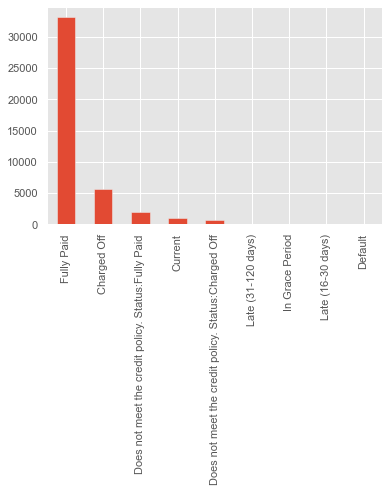

In [86]:
df['loan_status'].value_counts().plot(kind='bar');

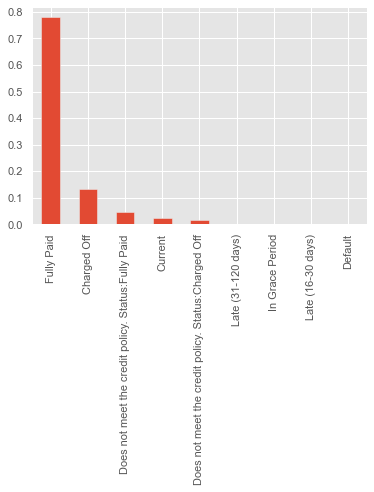

In [87]:
df['loan_status'].value_counts(normalize=True).plot(kind='bar');

**Current:** Loan is up to date on all outstanding payments. 
 
**In Grace Period:** Loan is past due but within the 15-day grace period. 
 
**Late (16-30):** Loan has not been current for 16 to 30 days. Learn more about the tools LendingClub has to deal with delinquent borrowers.
 
**Late (31-120):** Loan has not been current for 31 to 120 days. Learn more about the tools LendingClub has to deal with delinquent borrowers.
 
**Fully paid:** Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.
 
**Default:** Loan has not been current for an extended period of time. Learn more about the difference between “default” and “charge off”.
 
**Charged Off:** Loan for which there is no longer a reasonable expectation of further payments. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance. Learn more about the difference between “default” and “charge off”.

from https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

 According to the Lending Club, 'Does not meet the credit policy. Status: <>' are all those loans that were approved **before a change in credit policy**. With regard to Charged Off and defaults, a loan is considered a default if it has gone for more than 120 days with no payment. It is then be charged off not more that 30 days later.

The **data imbalance** is strong, no matter how we classify the target, we have a large number of fully paid credits and a remarkably smaller amount of data which has other values.

### Create Custom Target

In [88]:
# label "loan_status"
df.loan_status.value_counts()

Fully Paid                                             33136
Charged Off                                             5634
Does not meet the credit policy. Status:Fully Paid      1988
Current                                                  961
Does not meet the credit policy. Status:Charged Off      761
Late (31-120 days)                                        24
In Grace Period                                           20
Late (16-30 days)                                          8
Default                                                    3
Name: loan_status, dtype: int64

Since we cheched that there is not difference between the fully paid and "Does not meet the credit policy: Fully Paid" credits, we combine them to Fully Paid. The same for the Charged Off Credits.

In [89]:
# Combine defaults and paid back credits
def combine_loan_status(s): 
    if s == "Fully Paid" or s == "Does not meet the credit policy. Status:Fully Paid":
        s = 0
    elif s == "Charged Off" or s == "Does not meet the credit policy. Status:Charged Off" or s == "Default":
        s = 1
    else:
        s = 99
    return s

In [90]:
df['default'] = df.loan_status.apply(lambda x: combine_loan_status(x))

In [91]:
df.default.value_counts()

0     35124
1      6398
99     1016
Name: default, dtype: int64

In [92]:
df = df[df.default < 2]

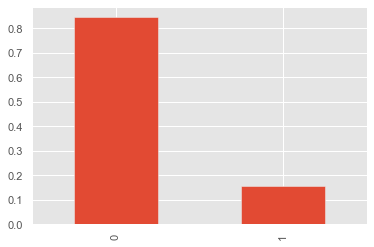

In [93]:
df['default'].value_counts(normalize=True).plot(kind='bar');

We focus on fully paid and default (charged off) credits and do not consider the current and late credits, since we can not estimate how these credits are developing in the future (e.g. we dont know if there will ebe payments in the future).

### Confusion Matrix

We have to decide on what kind of status is a default for us. The fully paid loand are our non default loans in this case.

The prediction we are trying to make if wheter a loan is default or fully paid back, therefore we have the following prediction types and these give us also the values of the confusion matrix.

Positive = Credit is a default

Negative = Credit is fully paid back

- False Negativ (FN) - **predict credit as fully paid back but it is actually a default** this is the worst case for investors
- True Negative (TN) - **predict the credit as fully paid back and giving the credit to borrower and the credit is fully paid back**
- False Positive (FP)- **predict a defaults and denying the loan to a client who will end up paying in full** this reduces the number of good borrowers.
-  True Positive (TP) - **predict credit as default which is actually a default** This protects our investors and the platform

Key intrests: 
- For investors: it is important to get return and get back the invested amount (principal + interest) - There should be no or very small amount of FP since these are then defaults and reduce the return.
- For LendingClub: Maximum profit is related to a low FN, since these borrowers are incorrectly predicted as defaults

The main concern here is to avoid approving somebody who won't be able to repay or in other words **avoid false negatives (FN)**. Therefore we need a **high recall rate**!



What would be the right performance metric- precision, recall, accuracy, F1 score, or something else?

The second case is the porfitability of LendingClub, where we want to **avoid a large number of false positives (FP)**. We can evaluate False positive rate (FPR) to be really small. Probability of false alarm = (Σ False positive) / (Σ Condition negative) to make sure we are not declined too many qualified borrowers.

![Recall, Precision](images/prec_recall.png)

from: https://en.wikipedia.org/wiki/Precision_and_recall

## Business Scenario

Since we dont have a lot of time we will first focus on **predicting the defaults with a high recall, this means avoiding false negatives.**

**2 Business Cases:**
1. one for investors **focus** avoid false negatives with a high recall score
2. one for LendingClub **focus** on Recall and small false postive rate (Accuracy is a good measure)

# Data Mining

The dataset was made available to us in the second project in the newly founded Data Science Bootcamp. The data was collected and provided by the Lending Club (lendingclub.com) from the years 2007 to 2010. In total there are 42538 entries in 52 columns.

Tasks
- Make a model to assess whether or not a new customer is likely to pay back the loan. You can use several different machine learning models.

- In the accepted loans data, we have a column called "grade." It takes values from A-G (A is the best, G is the worst). The task is to build a classifier that, given some other features, can accurately categorize a loan by grade.



# Data Cleaning
Purpose: Fix the inconsistencies within the data and handle the missing values

In [94]:
# new df for the inspections
df_insp = df.copy()

In [95]:
# check the shape
df_insp.shape

(41522, 53)

We already lost some entries due to the deletion of the datapoint which were neither default nor fully paid back.

In [96]:
# geht an overview over datatype and missings
df_insp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41522 entries, 0 to 42535
Data columns (total 53 columns):
id                            41522 non-null object
member_id                     41522 non-null float64
loan_amnt                     41522 non-null float64
funded_amnt                   41522 non-null float64
funded_amnt_inv               41522 non-null float64
term                          41522 non-null object
int_rate                      41522 non-null object
installment                   41522 non-null float64
grade                         41522 non-null object
sub_grade                     41522 non-null object
emp_title                     38966 non-null object
emp_length                    40451 non-null object
home_ownership                41522 non-null object
annual_inc                    41518 non-null float64
verification_status           41522 non-null object
issue_d                       41522 non-null object
loan_status                   41522 non-null object
p

Observations:
- there are at least 39909 entries "emp_title" 
- there are 22 object typed columns
- the column names are readable

In [97]:
# check the distribution of numerical features across the sample
df_insp.describe().round(0).transpose() 

,count,mean,std,min,25%,50%,75%,max
member_id,41522.0,817894.0,277845.0,70473.0,634095.0,816522.0,1022301.0,1314167.0
loan_amnt,41522.0,10935.0,7310.0,500.0,5000.0,9600.0,15000.0,35000.0
funded_amnt,41522.0,10674.0,7054.0,500.0,5000.0,9250.0,15000.0,35000.0
funded_amnt_inv,41522.0,9980.0,7029.0,0.0,4900.0,8336.0,13950.0,35000.0
installment,41522.0,321.0,209.0,16.0,165.0,275.0,424.0,1305.0
annual_inc,41518.0,68973.0,64473.0,1896.0,40000.0,58284.0,82000.0,6000000.0
dti,41522.0,13.0,7.0,0.0,8.0,13.0,19.0,30.0
delinq_2yrs,41493.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0
inq_last_6mths,41493.0,1.0,2.0,0.0,0.0,1.0,2.0,33.0
open_acc,41493.0,9.0,5.0,1.0,6.0,9.0,12.0,47.0


Observations:
- in lots of columns there seems to be little ranges and few entries at all ("out_prncp", "out_prncp_inv" ...)

In [98]:
# check the first entries in the dataset
df_insp.head(40).transpose()

,0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34,35,36,37,38,40,41,42
id,1077501,1077430,1077175,1076863,1075269,1069639,1072053,1071795,1071570,1070078,1069908,1064687,1069866,1069057,1069759,1065775,1069971,1062474,1069742,1069740,1039153,1069710,1069700,1069559,1069697,1069800,1069657,1069799,1047704,1032111,1069539,1069591,1069530,1069522,1069361,1069357,1069356,1067573,1069506,1069314
member_id,1.2966e+06,1.31417e+06,1.31352e+06,1.27718e+06,1.31144e+06,1.30474e+06,1.28869e+06,1.30696e+06,1.30672e+06,1.3052e+06,1.30501e+06,1.29872e+06,1.30496e+06,1.3035e+06,1.30487e+06,1.2997e+06,1.30488e+06,1.29454e+06,1.30486e+06,1.28485e+06,1.26908e+06,1.30482e+06,1.30481e+06,1.30463e+06,1.27377e+06,1.30468e+06,1.30476e+06,1.30468e+06,1.27881e+06,1.26174e+06,1.30461e+06,1.30429e+06,1.29136e+06,1.30459e+06,1.30426e+06,1.30425e+06,1.30425e+06,1.30196e+06,1.30457e+06,1.3042e+06
loan_amnt,5000,2500,2400,10000,5000,7000,3000,5600,5375,6500,12000,9000,3000,10000,1000,10000,3600,6000,9200,20250,21000,10000,10000,6000,15000,15000,5000,4000,8500,4375,31825,5000,7000,12400,10800,15000,6000,9600,12000,3000
funded_amnt,5000,2500,2400,10000,5000,7000,3000,5600,5375,6500,12000,9000,3000,10000,1000,10000,3600,6000,9200,20250,21000,10000,10000,6000,15000,15000,5000,4000,8500,4375,31825,5000,7000,12400,10800,15000,6000,9600,12000,3000
funded_amnt_inv,4975,2500,2400,10000,5000,7000,3000,5600,5350,6500,12000,9000,3000,10000,1000,10000,3600,6000,9200,19142.2,21000,10000,10000,6000,15000,8725,5000,4000,8500,4375,31825,5000,7000,12400,10800,15000,6000,9600,12000,3000
term,36 months,60 months,36 months,36 months,36 months,60 months,36 months,60 months,60 months,60 months,36 months,36 months,36 months,36 months,36 months,36 months,36 months,36 months,36 months,60 months,36 months,36 months,36 months,36 months,36 months,36 months,60 months,36 months,36 months,36 months,36 months,36 months,36 months,36 months,36 months,36 months,36 months,36 months,36 months,36 months
int_rate,10.65%,15.27%,15.96%,13.49%,7.90%,15.96%,18.64%,21.28%,12.69%,14.65%,12.69%,13.49%,9.91%,10.65%,16.29%,15.27%,6.03%,11.71%,6.03%,15.27%,12.42%,11.71%,11.71%,11.71%,9.91%,14.27%,16.77%,11.71%,11.71%,7.51%,7.90%,8.90%,15.96%,10.65%,9.91%,7.90%,12.42%,7.51%,7.90%,18.25%
installment,162.87,59.83,84.33,339.31,156.46,170.08,109.43,152.39,121.45,153.45,402.54,305.38,96.68,325.74,35.31,347.98,109.57,198.46,280.01,484.63,701.73,330.76,330.76,198.46,483.38,514.64,123.65,132.31,281.15,136.11,995.82,158.77,245.97,403.91,348.03,469.36,200.5,298.67,375.49,108.84
grade,B,C,C,C,A,C,E,F,B,C,B,C,B,B,D,C,A,B,A,C,B,B,B,B,B,C,D,B,B,A,A,A,C,B,B,A,B,A,A,D
sub_grade,B2,C4,C5,C1,A4,C5,E1,F2,B5,C3,B5,C1,B1,B2,D1,C4,A1,B3,A1,C4,B4,B3,B3,B3,B1,C2,D2,B3,B3,A3,A4,A5,C5,B2,B1,A4,B4,A3,A4,D5


In [99]:
# check value range
df_insp.tax_liens.value_counts()

0.0    41416
1.0        1
Name: tax_liens, dtype: int64

Observations:
-	“id” is just a key from Lenders Club (check for duplicates)
-	“member_id” is just a key from Lenders Club (check for duplicates)
-	“loan_amnt” equals “funded_amnt” (check)
-	“term” (transform into boolen “term_is_36”)
-	“int-rate” (transform to float)
-	“emp_title” lots of NaN (drop)
-	“emp_lenght” (transform into int)
-	“home_ownership” has four values RENT, MORTAGE, OWN and OTHER (136 entries)
-	“verification_status” has tree values “Not Verified”, “Verified” and “Source Verified” (check diffrences)
-	“issue_d” has a lot of values always Month-Year
-	“pymnt_plan” has only one not “n” entry “y” (drop)
-	“purpose” there are 14 different categories (make histogram)
-	“title” to many different values (drop)
-	“zip_code” only 3 digits given style “100xxx” (drop)
-	“dti” lots of missings only 2894 entries, but all in running credits
-	“initial_list_status” only one value “f” (drop)
-	“collections_12_mths_ex_med” only one value “0” (drop)
-	“policy_code” only one value “1” (drop)
-	“application_type” only one value “INDIVIDUAL” (drop)
-	“chargeoff_within_12_mths” only one value “0” (drop)
-	“acc_now_delinq” only for not “0” entries (drop)
-	“delinq_amnt” only two others than “0” - 42506 at all (drop)
- "pub_rec_bankruptcies" (flatten and transform bool "had_bankruptcy")
-	“tax_lines” only one other than “0” (drop)

Label / targets:
- “loan_status” is going to be the label (target)
- “grade” could be a classification label. Question which feature are important for “grade”?

In [100]:
df.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41522 entries, 0 to 42535
Data columns (total 22 columns):
id                     41522 non-null object
term                   41522 non-null object
int_rate               41522 non-null object
grade                  41522 non-null object
sub_grade              41522 non-null object
emp_title              38966 non-null object
emp_length             40451 non-null object
home_ownership         41522 non-null object
verification_status    41522 non-null object
issue_d                41522 non-null object
loan_status            41522 non-null object
pymnt_plan             41522 non-null object
purpose                41522 non-null object
title                  41509 non-null object
zip_code               41522 non-null object
addr_state             41522 non-null object
earliest_cr_line       41493 non-null object
revol_util             41432 non-null object
initial_list_status    41522 non-null object
last_pymnt_d           41439 non-nul

In [101]:
# check for appended entries
df_insp.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,...,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,default
42531,73582,73096.0,3500.0,3500.0,225.0,36 months,10.28%,113.39,C,C1,NaN,< 1 year,RENT,180000.0,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully ...,n,other,Wedding coming up,100xx,NY,10.00,NaN,NaN,...,0.0,NaN,NaN,f,0.0,0.0,3719.431070,239.11,3500.0,219.43,0.0,0.0,0.0,Mar-2008,0.00,Feb-2013,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN,0
42532,72998,72992.0,1000.0,1000.0,0.0,36 months,9.64%,32.11,B,B4,Halping hands company inc.,< 1 year,RENT,12000.0,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully ...,n,other,delight,021xx,MA,10.00,NaN,NaN,...,0.0,NaN,NaN,f,0.0,0.0,1155.600899,0.00,1000.0,155.60,0.0,0.0,0.0,Jun-2010,32.41,Sep-2014,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN,0
42533,72176,70868.0,2525.0,2525.0,225.0,36 months,9.33%,80.69,B,B3,NaN,< 1 year,RENT,110000.0,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully ...,n,other,Car repair bill,100xx,NY,10.00,NaN,NaN,...,0.0,NaN,NaN,f,0.0,0.0,2904.498829,258.82,2525.0,379.50,0.0,0.0,0.0,Jun-2010,82.03,May-2007,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN,0
42534,71623,70735.0,6500.0,6500.0,0.0,36 months,8.38%,204.84,A,A5,NaN,< 1 year,NONE,NaN,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully ...,n,other,Buying a car,100xx,NY,4.00,NaN,NaN,...,0.0,NaN,NaN,f,0.0,0.0,7373.904962,0.00,6500.0,873.90,0.0,0.0,0.0,Jun-2010,205.32,Aug-2007,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN,0
42535,70686,70681.0,5000.0,5000.0,0.0,36 months,7.75%,156.11,A,A3,Homemaker,10+ years,MORTGAGE,70000.0,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully ...,n,other,Aroundthehouse,068xx,CT,8.81,NaN,NaN,...,0.0,NaN,NaN,f,0.0,0.0,5619.762090,0.00,5000.0,619.76,0.0,0.0,0.0,Jun-2010,156.39,Feb-2015,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN,0


## Drop empty, useless and one value columns

In [102]:
# check for duplicates if non drop
print("---id---")
print(df_insp.id.duplicated().value_counts())
print("---member_id---")
print(df_insp.member_id.duplicated().value_counts())

---id---
False    41522
Name: id, dtype: int64
---member_id---
False    41522
Name: member_id, dtype: int64


In [103]:
# all of these features where the value range small (<10 diffrent entries)
drop_columns = ["id",
                "member_id",
                "pymnt_plan",
                "title",
                "zip_code",
                "initial_list_status",
                "collections_12_mths_ex_med",
                "policy_code",
                "application_type",
                "chargeoff_within_12_mths",
                "acc_now_delinq",
                "delinq_amnt",
                "tax_liens"]

## Handling missing

In [104]:
# check for missings
missing = pd.DataFrame(df_insp.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/df_insp.shape[0]*100,1)
missing[missing.Number!=0]

,Number,Percentage
emp_title,2556,6.2
emp_length,1071,2.6
annual_inc,4,0.0
title,13,0.0
delinq_2yrs,29,0.1
earliest_cr_line,29,0.1
inq_last_6mths,29,0.1
open_acc,29,0.1
pub_rec,29,0.1
revol_util,90,0.2


In [105]:
# all 0 rows dropped
df_insp.collections_12_mths_ex_med.value_counts()
# all 0 rows dropped
df_insp.chargeoff_within_12_mths.value_counts()
# 32 rows kicked cause lots of missing entries, see above
df_insp = df_insp[df_insp.delinq_amnt.notna()]
print(f"Shape df {df.shape}")
print(f"Shape df {df_insp.shape}")

df_insp = df_insp[df_insp.collections_12_mths_ex_med.notna()]
missing = pd.DataFrame(df_insp.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/df_insp.shape[0]*100,1)
missing[missing.Number!=0]

Shape df (41522, 53)
Shape df (41493, 53)


,Number,Percentage
emp_title,2532,6.1
emp_length,1071,2.6
title,13,0.0
revol_util,58,0.1
last_pymnt_d,83,0.2
last_credit_pull_d,2,0.0
pub_rec_bankruptcies,1225,3.0


In [106]:
# lots of diffrent entrys 6,2% missing (drop)
df_insp.emp_title.value_counts()

US Army                                     136
Bank of America                             114
IBM                                          71
Kaiser Permanente                            61
AT&T                                         58
UPS                                          57
Wells Fargo                                  55
US Air Force                                 55
USAF                                         53
Self Employed                                49
United States Air Force                      48
Walmart                                      47
Lockheed Martin                              44
Verizon Wireless                             43
U.S. Army                                    42
USPS                                         41
State of California                          40
Walgreens                                    40
US ARMY                                      39
Self                                         39
JPMorgan Chase                          

In [107]:
# fillna 2,6% with median
df_insp.emp_length.value_counts()

10+ years    9005
< 1 year     4945
2 years      4639
3 years      4282
4 years      3562
1 year       3506
5 years      3377
6 years      2321
7 years      1814
8 years      1548
9 years      1307
Name: emp_length, dtype: int64

In [108]:
# fillna woher kommt der wert? Selbsteinschätzung, dann max-wert, sonst null 3,2%
df_insp.pub_rec_bankruptcies.value_counts()

0.0    38336
1.0     1810
2.0        6
Name: pub_rec_bankruptcies, dtype: int64

**Informationsverlust, lieber neues Feature "hat schon mal gezahlt, gegen hat noch nie"**

In [109]:
# find NaN entries "last_pymnt_d" and "last_credit_pull_d"
df_insp.last_pymnt_d.value_counts()
df_insp.last_credit_pull_d.value_counts()

# cut rows with missings
df_insp = df_insp[df_insp.last_pymnt_d.notna()]
df_insp = df_insp[df_insp.last_credit_pull_d.notna()]

In [110]:
# missings table
missing = pd.DataFrame(df_insp.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/df_insp.shape[0]*100,2)
missing[missing.Number!=0]

,Number,Percentage
emp_title,2521,6.11
emp_length,1066,2.58
title,13,0.03
revol_util,54,0.13
pub_rec_bankruptcies,1222,2.96


In [111]:
# lots of diffrent values no generalisation possible (drop)
df_insp.title.value_counts()

Debt Consolidation                          2169
Debt Consolidation Loan                     1657
Personal Loan                                685
Consolidation                                523
debt consolidation                           509
Credit Card Consolidation                    366
Home Improvement                             360
Debt consolidation                           336
Personal                                     322
Small Business Loan                          313
Credit Card Loan                             309
personal loan                                258
Consolidation Loan                           258
Home Improvement Loan                        240
personal                                     236
Loan                                         212
Wedding Loan                                 207
consolidation                                204
Car Loan                                     197
Other Loan                                   180
Credit Card Payoff  

## Replace missing

Purpose: We handled the missigs, as suggested in this article: https://www.datasciencecentral.com/forum/topics/how-to-deal-with-missing-data.

### emp_length

In [112]:
df_insp.emp_length.value_counts()

10+ years    8995
< 1 year     4933
2 years      4631
3 years      4275
4 years      3554
1 year       3493
5 years      3367
6 years      2318
7 years      1813
8 years      1544
9 years      1303
Name: emp_length, dtype: int64

In [113]:
# fillna with median 2,6%
df_a = df_insp.copy()

# fillna woher kommt der wert? Selbsteinschätzung, dann max-wert, sonst null 3,2%
df_a.emp_length = df_a.emp_length.str.replace("< 1 year", "0 year")
df_a.emp_length = df_a.emp_length.str.split(' ').str[-2]
df_a.emp_length = df_a.emp_length.replace("10+", "10")
df_a.emp_length.value_counts()

10    8995
0     4933
2     4631
3     4275
4     3554
1     3493
5     3367
6     2318
7     1813
8     1544
9     1303
Name: emp_length, dtype: int64

Here we use the median due to the distribution

The median is of emp_length is 4.0
The distribution is shown in the plot


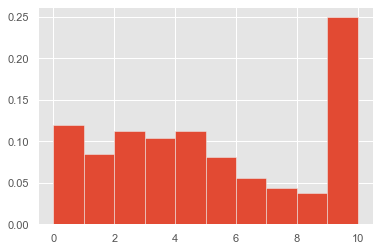

In [114]:
median_emplenght = df_a.emp_length.median()
print(f"The median is of emp_length is {median_emplenght}")
print("The distribution is shown in the plot")

# replace missings with median
df_a.emp_length.fillna(median_emplenght,inplace=True)
df_a.emp_length = df_a.emp_length.astype(int)
df_a.emp_length.hist(density=1);

In [115]:
df_a.emp_length.value_counts()

10    8995
0     4933
2     4631
4     4620
3     4275
1     3493
5     3367
6     2318
7     1813
8     1544
9     1303
Name: emp_length, dtype: int64

In [116]:
# rewrite to df_insp
df_insp.emp_length = df_a.emp_length

### pub_rec_bankruptcies

In [117]:
df_insp.pub_rec_bankruptcies.value_counts()

0.0    38261
1.0     1803
2.0        6
Name: pub_rec_bankruptcies, dtype: int64

In [118]:
# no info about bankruptcie will be interpreted as none
df_insp.pub_rec_bankruptcies = df_insp.pub_rec_bankruptcies.fillna(0.0).astype('uint8')
# flatten the entries (8) that have amount of 2 new values 0 or 1
df_insp.pub_rec_bankruptcies = df_insp.pub_rec_bankruptcies.apply(lambda x: 1 if x > 0 else 0)
df_insp.pub_rec_bankruptcies.value_counts()

0    39483
1     1809
Name: pub_rec_bankruptcies, dtype: int64

### revol_util

In [119]:
df_insp.revol_util.fillna(0, inplace=True)

missing = pd.DataFrame(df_insp.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/df_insp.shape[0]*100,2)
missing[missing.Number!=0]

,Number,Percentage
emp_title,2521,6.11
title,13,0.03


## Drop Columns 

In [120]:
# drops: all of these features value range is either complete 0 or NaN
drop_columns_zeros = ["emp_title"]

drop_columns += drop_columns_zeros

In [121]:
df_insp.drop(columns=drop_columns,inplace=True,axis=1)

## Change Value Type to usable values (object types)

In [122]:
df_insp.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41292 entries, 0 to 42449
Data columns (total 14 columns):
term                   41292 non-null object
int_rate               41292 non-null object
grade                  41292 non-null object
sub_grade              41292 non-null object
home_ownership         41292 non-null object
verification_status    41292 non-null object
issue_d                41292 non-null object
loan_status            41292 non-null object
purpose                41292 non-null object
addr_state             41292 non-null object
earliest_cr_line       41292 non-null object
revol_util             41292 non-null object
last_pymnt_d           41292 non-null object
last_credit_pull_d     41292 non-null object
dtypes: object(14)
memory usage: 4.7+ MB


### Fix term to bool

In [123]:
df_insp.term.value_counts()

 36 months    31322
 60 months     9970
Name: term, dtype: int64

In [124]:
# Convert term to bool "term_is_36"
def term_to_bool(s): 
    term = int(str(s).split(" ")[1])
    if term == 36:
        term = 1
    else:
        term = 0
    return term

In [125]:
df_insp.term = df_insp.term.apply(lambda x: term_to_bool(x))

In [126]:
df_insp.rename(columns={'term':'term_is_36'}, inplace=True)
df_insp.term_is_36.value_counts()

1    31322
0     9970
Name: term_is_36, dtype: int64

### Fix rates to float (interest and revol util)

In [127]:
# Convert int rate to float (decimal number)
def rates_to_float(s): 
    s = str(s).split("%")[0]
    s = float(s)/100.0
    return s

In [128]:
df_insp['int_rate'] = df_insp.int_rate.apply(lambda x: rates_to_float(x))
df_insp['int_rate'].value_counts()

0.1099    940
0.1149    802
0.0751    786
0.1349    759
0.0788    742
0.0749    652
0.0999    597
0.0790    574
0.0542    573
0.1171    563
0.1199    491
0.1037    469
0.1269    452
0.0603    447
0.0849    439
0.1299    423
0.1186    415
0.0579    410
0.1242    407
0.1065    404
0.0729    397
0.0662    396
0.0963    384
0.0890    384
0.1059    374
0.0991    357
0.1253    355
0.0599    346
0.0714    342
0.1427    342
         ... 
0.1457      3
0.1886      3
0.1849      3
0.2069      3
0.1646      3
0.1467      3
0.1262      3
0.2411      3
0.2182      2
0.2020      2
0.2294      2
0.1759      2
0.1709      2
0.1633      2
0.1791      2
0.1728      2
0.1384      2
0.2440      1
0.1741      1
0.1683      1
0.2459      1
0.1620      1
0.1772      1
0.2264      1
0.1691      1
0.1746      1
0.1872      1
0.2148      1
0.1744      1
0.1778      1
Name: int_rate, Length: 394, dtype: int64

In [129]:
df_insp['revol_util'] = df_insp.revol_util.apply(lambda x: rates_to_float(x))
df_insp['revol_util'].value_counts()

0.0000    1100
0.4070      64
0.6300      63
0.0020      63
0.6660      60
0.7040      60
0.0010      60
0.6460      59
0.3120      59
0.4640      59
0.4660      58
0.3760      58
0.6670      58
0.5740      58
0.3440      57
0.3530      57
0.6100      57
0.7660      56
0.5580      56
0.4800      56
0.2550      56
0.8950      56
0.5770      56
0.5520      55
0.6690      55
0.7080      55
0.6480      55
0.3090      55
0.8990      55
0.7210      55
          ... 
0.0858       1
0.5756       1
0.7763       1
0.6998       1
0.4969       1
0.0533       1
0.0846       1
0.3271       1
1.0060       1
0.3773       1
0.2533       1
0.4736       1
0.3877       1
0.0004       1
1.0390       1
1.0150       1
0.0801       1
0.0054       1
0.0075       1
0.0534       1
0.1008       1
0.0005       1
0.2465       1
0.0743       1
1.0880       1
0.5819       1
0.5258       1
0.4338       1
0.2159       1
0.0016       1
Name: revol_util, Length: 1117, dtype: int64

### Fix verification_status to bool

In [130]:
df_insp.verification_status.value_counts()

Not Verified       18374
Verified           12905
Source Verified    10013
Name: verification_status, dtype: int64

In [131]:
# Convert verification_status to bool
def verification_status_to_bool(s): 
    if s == "Not Verified":
        s = 0
    else:
        s = 1
    return s

df_insp['verification_status'] = df_insp.verification_status.apply(lambda x: verification_status_to_bool(x))
df_insp['verification_status'].value_counts()

1    22918
0    18374
Name: verification_status, dtype: int64

### Fix home_ownership to bool

In [132]:
df_insp.home_ownership.value_counts()

RENT        19681
MORTGAGE    18311
OWN          3162
OTHER         136
NONE            2
Name: home_ownership, dtype: int64

In [133]:
# Convert home_ownership to bool
def home_ownerschip_to_bool(s): 
    if s == "OWN":
        s = 1
    else:
        s = 0
    return s

df_insp['home_ownership'] = df_insp.home_ownership.apply(lambda x: home_ownerschip_to_bool(x))
df_insp['home_ownership'].value_counts()

0    38130
1     3162
Name: home_ownership, dtype: int64

## Conclusion

We are now giving an overview of the remaining data with the number of null values and the datatype.

In [134]:
def meta (dataframe):
    metadata = []
    for f in df_insp.columns:
    
        # Counting null values
        null = df_insp[f].isnull().sum()
    
        # Defining the data type 
        dtype = df_insp[f].dtype
    
        # Creating a Dict that contains all the metadata for the variable
        f_dict = {
            'varname': f,
            'nulls':null,
            'dtype': dtype
        }
        metadata.append(f_dict)

    meta = pd.DataFrame(metadata, columns=['varname','nulls', 'dtype'])
    meta.set_index('varname', inplace=True)
    meta=meta.sort_values(by=['nulls'],ascending=False)
    return meta


# data loss and metadata
print(f'{round((1-df_insp.shape[0]/df.shape[0])*100,3)}% data loss after cleaning')
print(f"Shape before cleaning {df.shape}")
print(f"Shape after cleaning  {df_insp.shape}")
meta(df_insp)

0.554% data loss after cleaning
Shape before cleaning (41522, 53)
Shape after cleaning  (41292, 39)


,nulls,dtype
varname,,
loan_amnt,0,float64
total_rec_prncp,0,float64
revol_bal,0,float64
revol_util,0,float64
total_acc,0,float64
out_prncp,0,float64
out_prncp_inv,0,float64
total_pymnt,0,float64
total_pymnt_inv,0,float64


We have a loss of about 0.554 % of the data and 39 remaining columns.  

Now we drop all date related features since they are not useful for our prediction of a default:

- last_pyment_d: This is only relevant for current or late credits to know, when the last payment took place.

- last_credit_pull_d: This gives the last date when a credit was pulled. This might be usefull for late credits.

- earliest_cr_line: This gives the month the borrower's earliest credit line was opened. This is not useful for our prediction since we are looking only on single credits. We don't have duplicate borrowers in our dataset.

- issue_d: The day the loan was issued is not related to the occurence of a default. 

- loan_status: This is dropped since we created our custom label "default (0 = No default, 1 = default)


In [135]:
# drop all objects that include dates and the feature "loan_status"
drop_columns = ["last_pymnt_d", "last_credit_pull_d", "earliest_cr_line", "issue_d", "loan_status"]
df_insp.drop(drop_columns, inplace=True, axis=1)
df_insp.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41292 entries, 0 to 42449
Data columns (total 4 columns):
grade         41292 non-null object
sub_grade     41292 non-null object
purpose       41292 non-null object
addr_state    41292 non-null object
dtypes: object(4)
memory usage: 1.6+ MB


## Write Output to file

# Data Exploration - EDA


Set up global variables for plot sizes:

In [136]:
import matplotlib
matplotlib.rc('font', size=20)          # controls default text sizes
matplotlib.rc('axes', titlesize=16)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=18)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=18)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=18)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=14)    # legend fontsize
matplotlib.rc('figure', titlesize=20)

After the cleaning of the data and defining the target varible (or label) as a credit to be a default (Positive, default = 0), in the EDA we are looking on the features, their distibution and the dependence on the target. 

## Target Variable Analysis

We start with the distribution of the default of the credits to see, what are the proportions of the defaults.

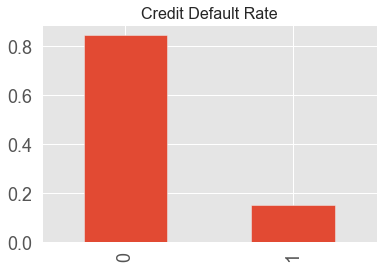

In [137]:
df['default'].value_counts(normalize=True).plot(kind='bar');
plt.title('Credit Default Rate');

There is a remarkably higher rate of fully paid credits compared to default credits. This should be considered when data is split to train and test sets, since the distribution on defaults should be representative for each split.

## Feature Analysis

Here we get an overview of the influence of different features on the credit default. 

### Grade and subgrade

Here we get an overview of the grading system. There is the grade which is a higher level grade (A to G) and there is a subgrading system with each 5 subgrades (A1,A2,A3,A4,A5 etc) and the values are from A1 to G5.

In [138]:
df['grade'].value_counts().sort_index()

A    10150
B    12081
C     8508
D     5813
E     3236
F     1239
G      495
Name: grade, dtype: int64

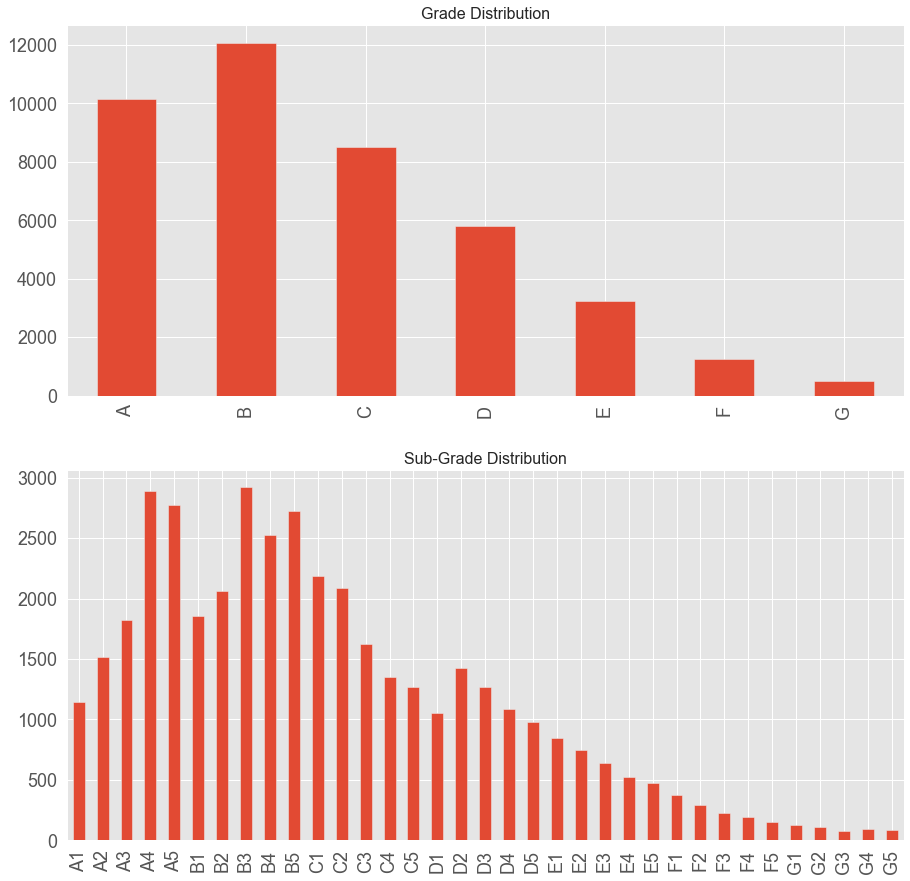

In [139]:
fig = plt.figure(figsize=(15,15))

plt.subplot(2,1,1)
df['grade'].value_counts().sort_index().plot(kind='bar',title='Grade Distribution',)

plt.subplot(2,1,2)
df['sub_grade'].value_counts().sort_index().plot(kind='bar',title='Sub-Grade Distribution')

plt.savefig('plots//grade_subgrade_total.png',dpi=300,bbox_inches='tight')

Now we caluculate the percentage values for both grading systems.

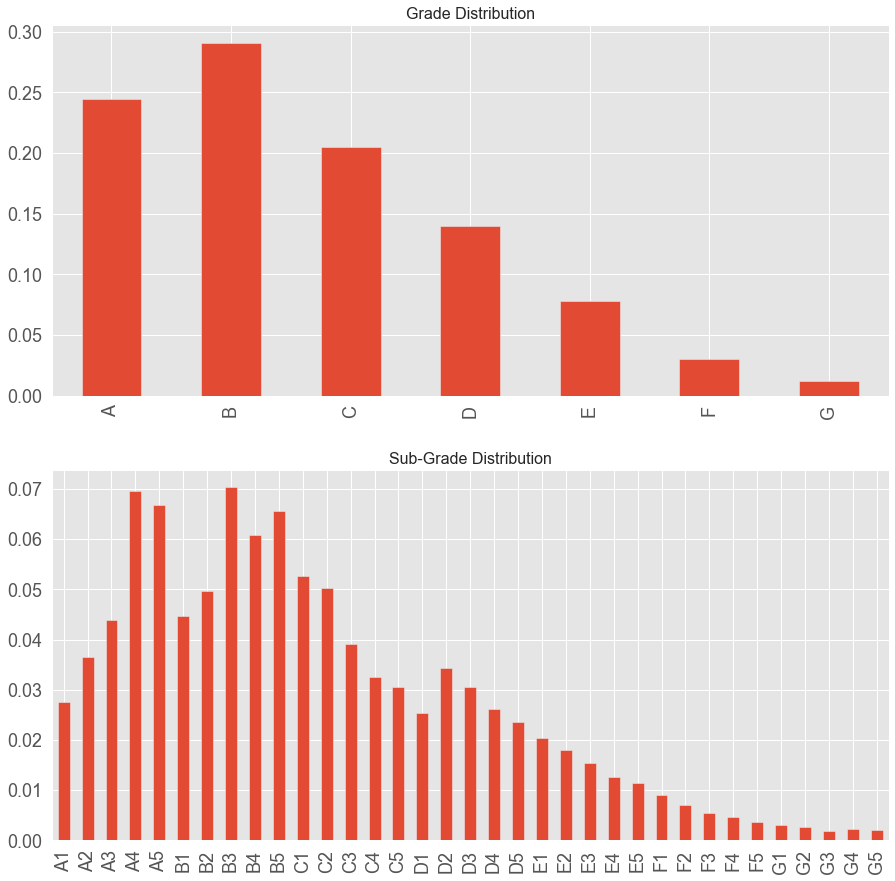

In [140]:
fig = plt.figure(figsize=(15,15))

plt.subplot(2,1,1)
df['grade'].value_counts(normalize=True).sort_index().plot(kind='bar',title='Grade Distribution');

plt.subplot(2,1,2)
df['sub_grade'].value_counts(normalize=True).sort_index().plot(kind='bar',title='Sub-Grade Distribution');

plt.savefig('plots/grade_subgrade_perc.png',dpi=300,bbox_inches='tight')

To get an idea how the grading is related to the default rate, we have a look on the distribution of defaults on the grading system. The lower the grading, the higher the defaults rate might be. 

In [141]:
# create a cross table with high grading (A to G) and the default values
grade_defaults = pd.crosstab(df_insp.grade, df_insp.default)

In [142]:
grade_defaults

default,0,1
grade,,
A,9505,603
B,10542,1493
C,6991,1463
D,4481,1298
E,2347,859
F,821,403
G,319,167


Normalize the values by the sum of each row.

In [143]:
# get the sum to normalize
grade_defaults.sum(1)

grade
A    10108
B    12035
C     8454
D     5779
E     3206
F     1224
G      486
dtype: int64

In [144]:
# convert to pecentage values
grade_defaults = grade_defaults.div(grade_defaults.sum(1),axis=0)

In [145]:
grade_defaults

default,0,1
grade,,
A,0.940344,0.059656
B,0.875945,0.124055
C,0.826946,0.173054
D,0.775394,0.224606
E,0.732065,0.267935
F,0.670752,0.329248
G,0.656379,0.343621


Now we can plot the distribution of defaults based on the grading.

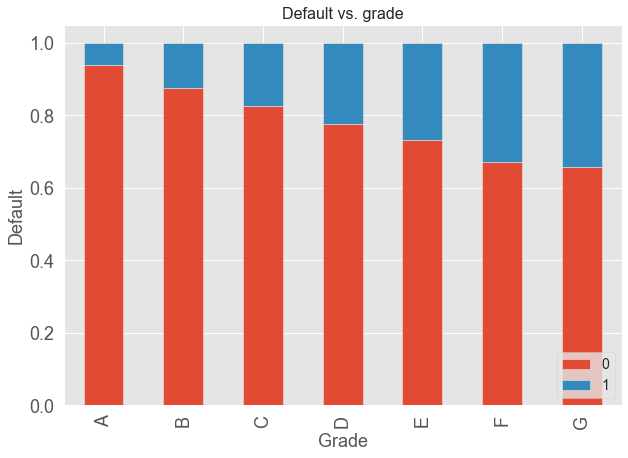

In [146]:
# plot the distribution of grades on defaults 
#fig = plt.figure(figsize=(10,7));
grade_defaults.plot(kind='bar', stacked=True, title='Default vs. grade',figsize=(10,7));
plt.xlabel('Grade')
plt.ylabel('Default')
plt.legend(loc='lower right');
plt.savefig('plots/grade_defaults_perc.png',dpi=300,bbox_inches='tight')

The overall default rate increases from A (5.9 %) with the grading up to F grading, with almost same default rate for F (31.3 %) and G (33.2%). 

We will do the same for the sub grading system, to get an idea of the influence of the sub grading system on the credit defaults.

In [147]:
# create a cross table with high grading (A to G) and the default values
sub_grade_defaults = pd.crosstab(df_insp.sub_grade, df_insp.default)

In [148]:
# convert to pecentage values
sub_grade_defaults = sub_grade_defaults.div(sub_grade_defaults.sum(1),axis=0)

In [149]:
sub_grade_defaults

default,0,1
sub_grade,,
A1,0.973638,0.026362
A2,0.949468,0.050532
A3,0.943833,0.056167
A4,0.938344,0.061656
A5,0.921462,0.078538
B1,0.900379,0.099621
B2,0.885214,0.114786
B3,0.878476,0.121524
B4,0.862839,0.137161


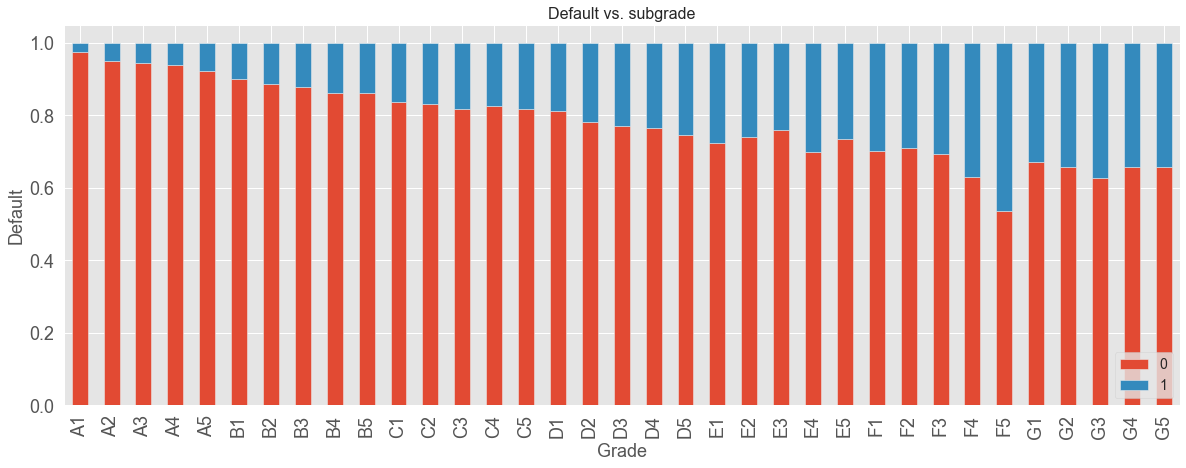

In [150]:
# plot the distribution of grades on defaults 
#fig = plt.figure(figsize=(20,7));
sub_grade_defaults.plot(kind='bar', stacked=True, title='Default vs. subgrade',figsize=(20,7));
plt.xlabel('Grade')
plt.ylabel('Default')
plt.legend(loc='lower right');
plt.savefig('plots/subgrade_defaults_perc.png',dpi=300,bbox_inches='tight')

The subgrad distribution on the defaults looks similar, therefore the subgrading system is slightly more detailled.  There is a more irregular pattern for the lower clases, E, F and G observed. 

In [151]:
df_insp.groupby('grade').grade.count()

grade
A    10108
B    12035
C     8454
D     5779
E     3206
F     1224
G      486
Name: grade, dtype: int64

Finally we will have a look on the distribution of the grades as counts and as percentage.

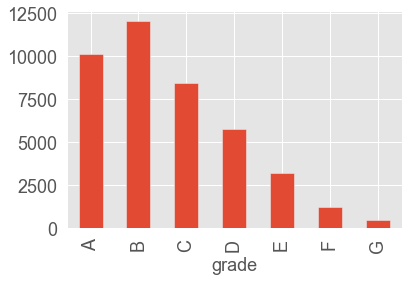

In [152]:
df_insp.groupby('grade').grade.count().plot(kind='bar')
plt.savefig('plots/grade_absolute.png',dpi=300,bbox_inches='tight')

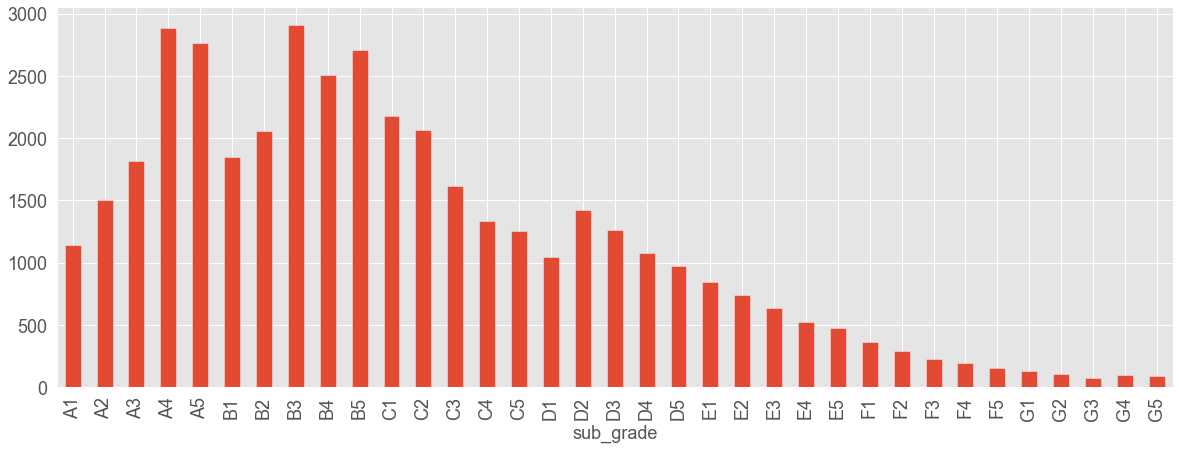

In [153]:
df_insp.groupby('sub_grade').sub_grade.count().plot(kind='bar',figsize=(20,7))
plt.savefig('plots/sub_grade_absolute.png',dpi=300,bbox_inches='tight')

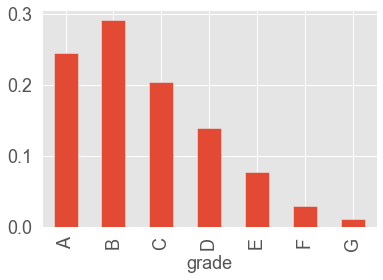

In [154]:
df_insp.groupby('grade').grade.count().div(df_insp.groupby('grade').grade.count().sum()).plot(kind='bar')
plt.savefig('plots/grade_perc.png',dpi=300,bbox_inches='tight')

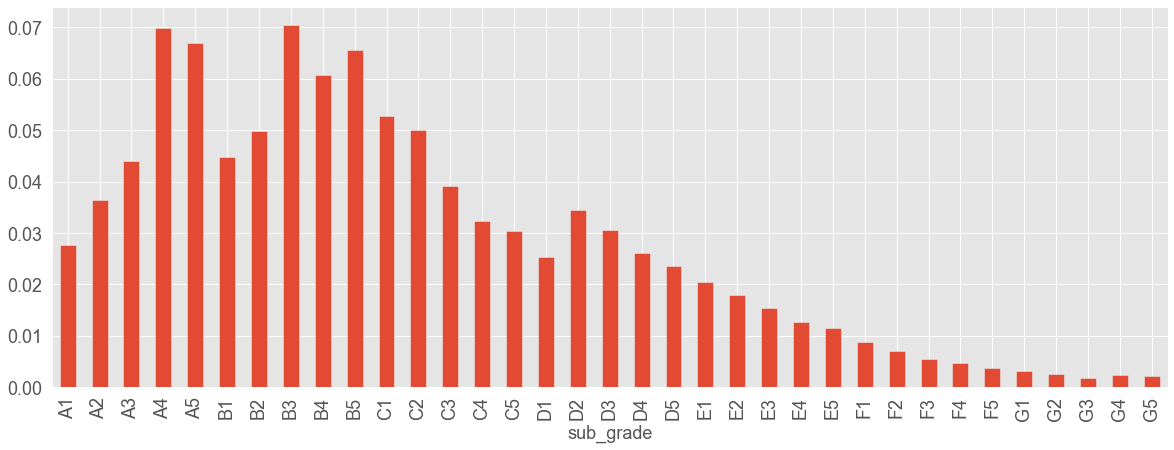

In [155]:
df_insp.groupby('sub_grade').sub_grade.count().div(df_insp.groupby('sub_grade').sub_grade.count().sum()).plot(kind='bar', figsize=(20,7))
plt.savefig('plots/sub_grade_perc.png',dpi=300,bbox_inches='tight')

Conclusion for **grade** and **subgrade**:

- both features seem to influence the credit default, the grade seems to be more compact and shows less fluctuation on the default rate

- either **one of both features** seems to be usefull for predictive modelling


### Loan Term

Text(0, 0.5, 'Default')

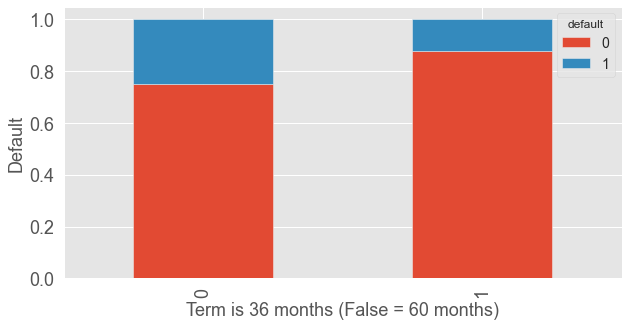

In [156]:
term_default = pd.crosstab(df_insp.term_is_36, df_insp.default)
term_default = term_default.div(term_default.sum(1),axis=0)


term_default.plot(kind='bar', stacked=True,figsize=(10,5))
plt.xlabel('Term is 36 months (False = 60 months)')
plt.ylabel('Default')

In [157]:
term_default

default,0,1
term_is_36,,
0,0.748847,0.251153
1,0.879254,0.120746


Conclusion for term:

- the term is an important feature, since credit with 36 months only have 12 % default rate and credit with 60 months have 25 % default rate. 

### Loan Amount

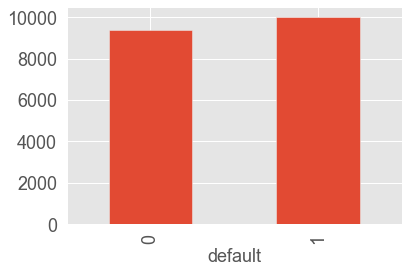

In [158]:
df_insp.groupby('default').loan_amnt.median().plot(kind='bar');

There is no strong difference between the median values. Lets try some loan amount bins.

In [159]:
df_insp.loan_amnt.max()

35000.0

In [160]:
lamnt_bins = np.arange(0, 35000, 2500)
lamnt_bins

array([    0,  2500,  5000,  7500, 10000, 12500, 15000, 17500, 20000,
       22500, 25000, 27500, 30000, 32500])

In [161]:
lamt_bin_series = pd.cut(df_insp['loan_amnt'], bins=lamnt_bins, labels=lamnt_bins[:-1])
lamt_bin_series.name = 'lamt_bin_2500'

In [162]:
lamt_cross_def = pd.crosstab(lamt_bin_series, df_insp.default)
lamt_cross_def

default,0,1
lamt_bin_2500,,
0,2381,431
2500,6453,1064
5000,5488,824
7500,6345,1063
10000,3424,556
12500,3535,620
15000,1427,321
17500,2385,483
20000,567,156


In [163]:
lamt_cross_def = lamt_cross_def.div(lamt_cross_def.sum(1), axis=0)

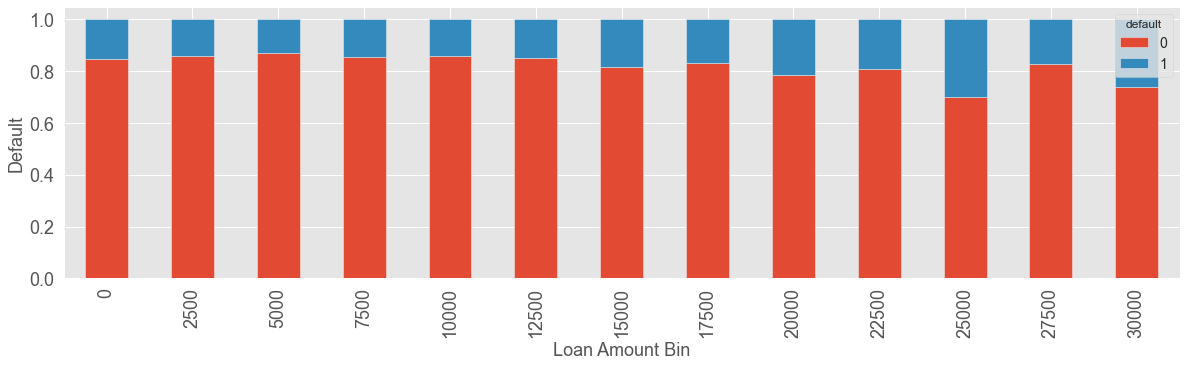

In [164]:
lamt_cross_def.plot(kind='bar', stacked=True, figsize=(20,5))
plt.xlabel('Loan Amount Bin')
plt.ylabel('Default')
plt.savefig('plots/loan_amount_defaults.png',dpi=300,bbox_inches='tight')
plt.savefig('plots/loan_amount_defaults.pdf',bbox_inches='tight')

Conclusion for loan amount:

- The influence of the loan amount on the defaults is relatively low up to 12500 to 15000 dollar, afterwards there are higher default rates for higher amounts.

### Interest Rate

The higher the interest rate, the higher the risk and with that the risk of a default. Lets first look on a box plot for interest rates on the default. 

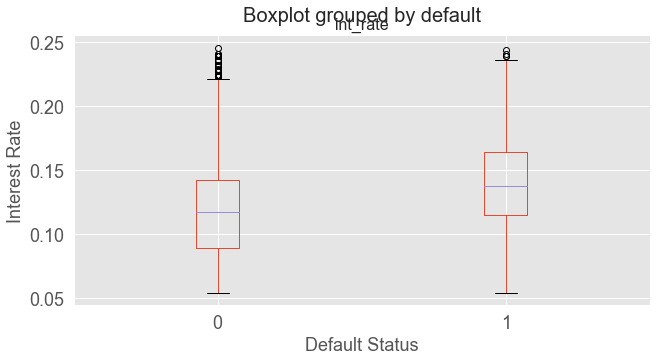

In [165]:
# interest rate boxplot for credit default
df_insp.boxplot(column="int_rate",by="default", figsize=(10,5));
plt.xlabel('Default Status')
plt.ylabel('Interest Rate')

plt.savefig('plots/int_rate_defaults.png',dpi=300,bbox_inches='tight')
plt.savefig('plots/int_rate_defaults.pdf',bbox_inches='tight')

The interest rate is remrkably higher for defaults and therefore credits with higher risk. We can also observe some outliers in the data, with higher interest rates for non default credits (these are high risk credits that have been fully paid back). Therefore the interest rate should not be cleaned.

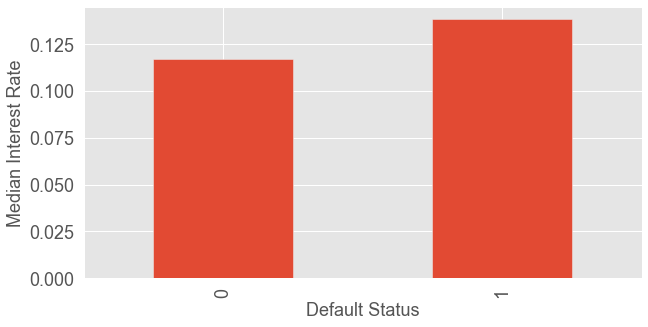

In [166]:
# interest rate boxplot for credit default
df_insp.groupby('default').int_rate.median().plot(kind='bar', figsize=(10,5))
plt.xlabel('Default Status')
plt.ylabel('Median Interest Rate')

plt.savefig('plots/int_rate_median_defaults.png',dpi=300,bbox_inches='tight')
plt.savefig('plots/int_rate_median_defaults.pdf',bbox_inches='tight')

In [167]:
df_insp.int_rate.max()

0.2459

In [168]:
int_rate_bins = np.arange(0, 0.25, 0.025)
int_rate_bins

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225])

In [169]:
int_rate_bin_series = pd.cut(df_insp['int_rate'], bins=int_rate_bins, labels=int_rate_bins[:-1])
int_rate_bin_series.name = 'int_bin_2.5'
int_rate_bin_series

0        0.100
1        0.150
2        0.150
3        0.125
5        0.075
6        0.150
7        0.175
8        0.200
9        0.125
10       0.125
11       0.125
12       0.125
13       0.075
14       0.100
15       0.150
16       0.150
17       0.050
18       0.100
19       0.050
20       0.150
21       0.100
22       0.100
23       0.100
24       0.100
25       0.075
27       0.150
28       0.100
29       0.100
30       0.075
31       0.075
         ...  
42418    0.075
42419    0.125
42420    0.150
42421    0.175
42422    0.125
42423    0.150
42424    0.125
42425    0.150
42426    0.100
42427    0.100
42428    0.100
42429    0.125
42430    0.100
42431    0.150
42432    0.150
42434    0.125
42435    0.100
42436    0.125
42437    0.150
42438    0.150
42439    0.150
42440    0.050
42441    0.150
42442    0.100
42443    0.125
42444    0.100
42445    0.075
42446    0.075
42448    0.100
42449    0.100
Name: int_bin_2.5, Length: 41292, dtype: category
Categories (9, float64): [0.000 < 0

In [170]:
int_rate_cross = pd.crosstab(int_rate_bin_series, df_insp.default)
int_rate_cross

default,0,1
int_bin_2.5,,
0.050,5117,257
0.075,6489,595
0.100,8502,1339
0.125,8228,1711
0.150,4459,1370
0.175,1682,697
0.200,492,287


In [171]:
int_rate_cross = int_rate_cross.div(int_rate_cross.sum(1), axis=0)

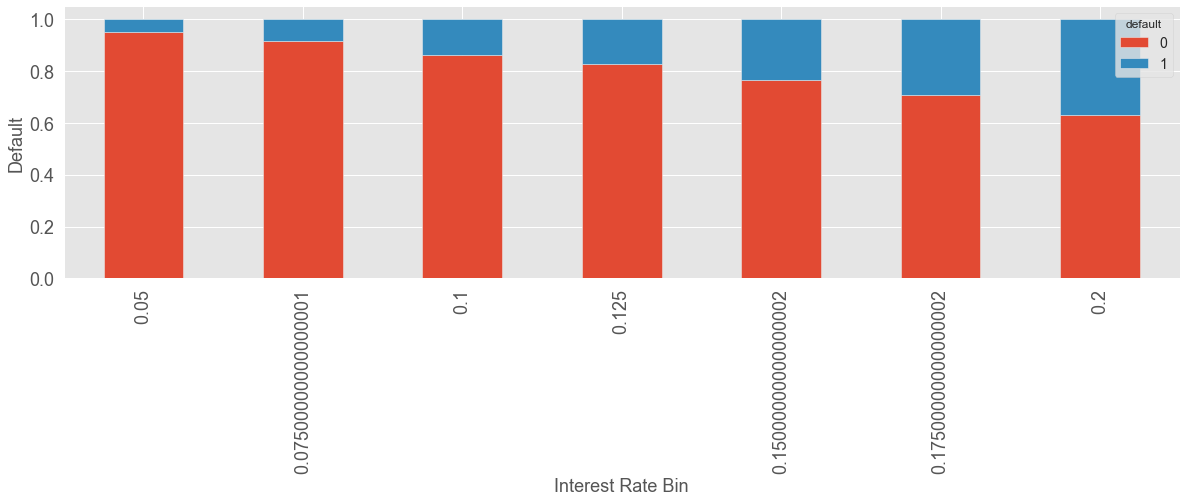

In [172]:
int_rate_cross.plot(kind='bar', stacked=True, figsize=(20,5))
plt.xlabel('Interest Rate Bin')
plt.ylabel('Default')
plt.savefig('plots/int_rate_defaults.png',dpi=300,bbox_inches='tight')
plt.savefig('plots/int_rate_defaults.pdf',bbox_inches='tight')

Conclusion for int rate:

- The value of the interest rate on the defaults is highly correlated with the defauls, therefore the interest rate should be included as a feature.

### State

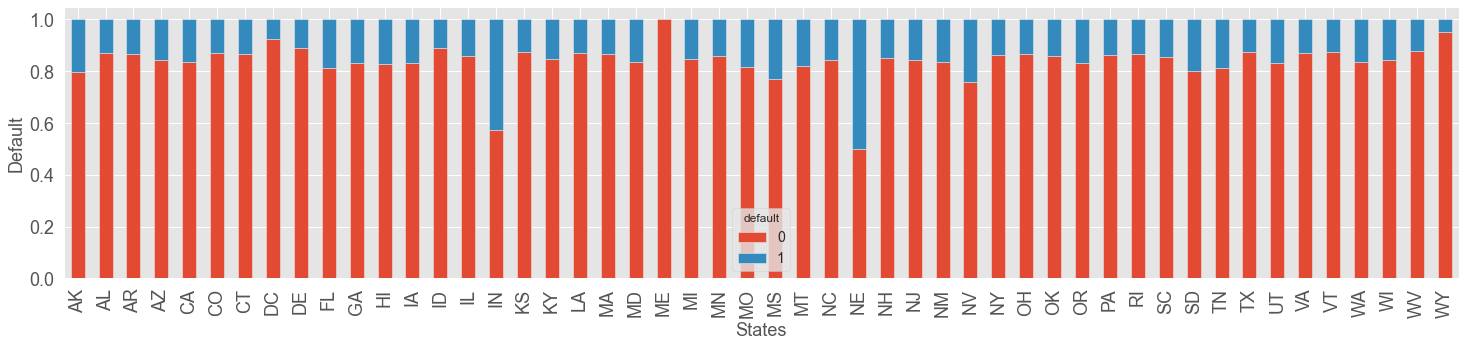

In [173]:
states = pd.crosstab(df_insp.addr_state , df_insp.default)
states = states.div(states.sum(1),axis=0)


states.plot(kind='bar', stacked=True, figsize=(25,5))
plt.xlabel('States')
plt.ylabel('Default')
plt.savefig('plots/states_defaults.png',dpi=300,bbox_inches='tight')
plt.savefig('plots/states_defaults.pdf',bbox_inches='tight')

In [ ]:
# distribution by state

Conclusion for state:

- There is a regional statewise influence on the default rate, and some states have remarkably higher default rates than others. 

### Purpose

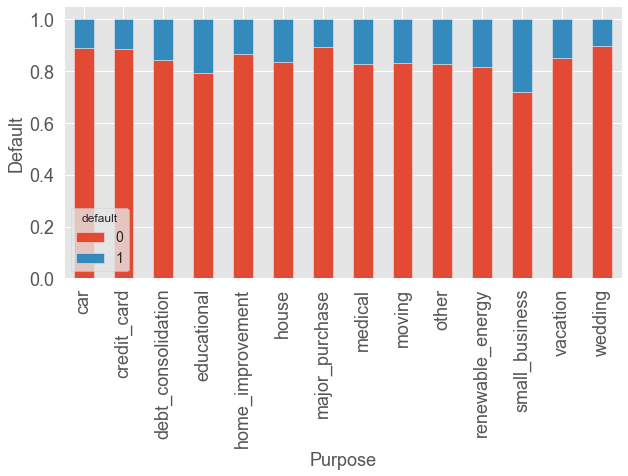

In [174]:
purpose = pd.crosstab(df_insp.purpose , df_insp.default)
purpose = purpose.div(purpose.sum(1), axis=0)


purpose.plot(kind='bar', stacked=True,figsize=(10,5))
plt.xlabel('Purpose')
plt.ylabel('Default')
plt.savefig('plots/purpose_defaults.png',dpi=300,bbox_inches='tight')
plt.savefig('plots/purpose_defaults.pdf',bbox_inches='tight')

Conclusion for purpose:

- The official purpose of the loan (defined by LendingClub epmloyees) is influencing the credit defaults, in particular the small business purpose shows a remarkably higher default rate. 

### Dept to Income Ratio - DTI

https://www.lendingclub.com/loans/resource-center/calculating-debt-to-income

In [175]:
dti_bins = np.arange(0, 32.5, 2.5)

In [176]:
dti_bins

array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ,
       27.5, 30. ])

In [177]:
dti_bin_series = pd.cut(df_insp['dti'], bins=dti_bins, labels=dti_bins[:-1])

In [178]:
dti_bin_series.name = 'dti_bin_5p'

In [179]:
dti_inf = pd.crosstab(dti_bin_series, df_insp.default)
dti_inf

default,0,1
dti_bin_5p,,
0.0,1993,291
2.5,2555,368
5.0,3284,466
7.5,3914,634
10.0,4231,715
12.5,4425,840
15.0,4114,774
17.5,3791,778
20.0,3270,690


In [180]:
dti_inf = dti_inf.div(dti_inf.sum(1), axis=0)

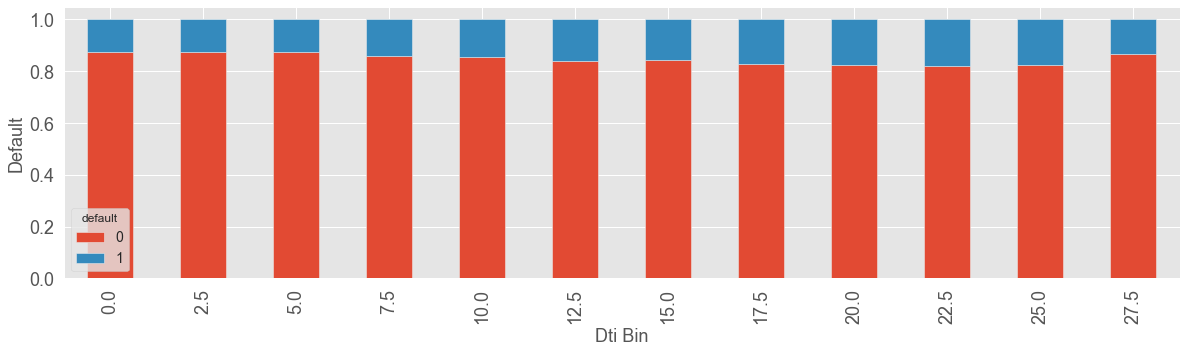

In [181]:
dti_inf.plot(kind='bar', stacked=True, figsize=(20,5))
plt.xlabel('Dti Bin')
plt.ylabel('Default')
plt.savefig('plots/dti_defaults.png',dpi=300,bbox_inches='tight')
plt.savefig('plots/dti_defaults.pdf',bbox_inches='tight')

Conclusion for dept to income:

- The risk of a default slightly increases by the dti ratio, the higher the dept is compared to the income the higher the risk of a default. This should be included as a feature. 

### Home Ownership

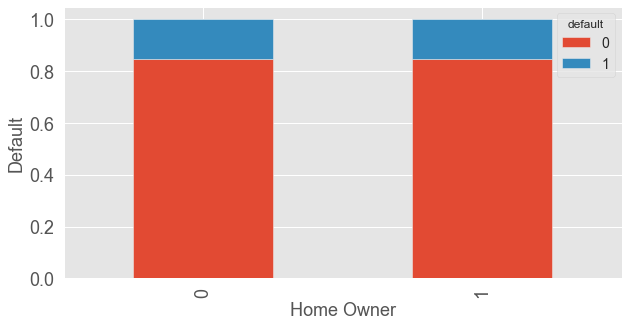

In [183]:
home_owner = pd.crosstab(df_insp.home_ownership, df.default)
home_owner = home_owner.div(home_owner.sum(1), axis=0)


home_owner.plot(kind='bar', stacked=True, figsize=(10,5))
plt.xlabel('Home Owner')
plt.ylabel('Default')
plt.savefig('plots/home_owner_defaults.png',dpi=300,bbox_inches='tight')
plt.savefig('plots/home_owner_defaults.pdf',bbox_inches='tight')

Conclusion for home ownership:

- The risk of a default is not dependent of the home ownership feature.

### Verification of income

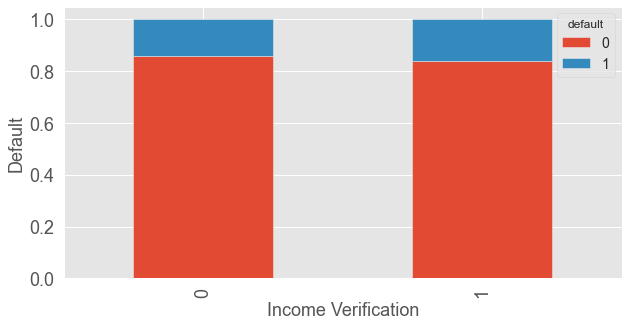

In [184]:
verification = pd.crosstab(df_insp.verification_status, df_insp.default)
verification = verification.div(verification.sum(1),axis=0)


verification.plot(kind='bar', stacked=True,figsize=(10,5))
plt.xlabel('Income Verification')
plt.ylabel('Default')
plt.savefig('plots/verification_defaults.png',dpi=300,bbox_inches='tight')
plt.savefig('plots/verification_defaults.pdf',bbox_inches='tight')

Conclusion for income verfification:

- If the income is verfied there is no strong influence on the default rate. 

## Handling of Ouliers and Scaling

ValueError: num must be 1 <= num <= 27, not 28

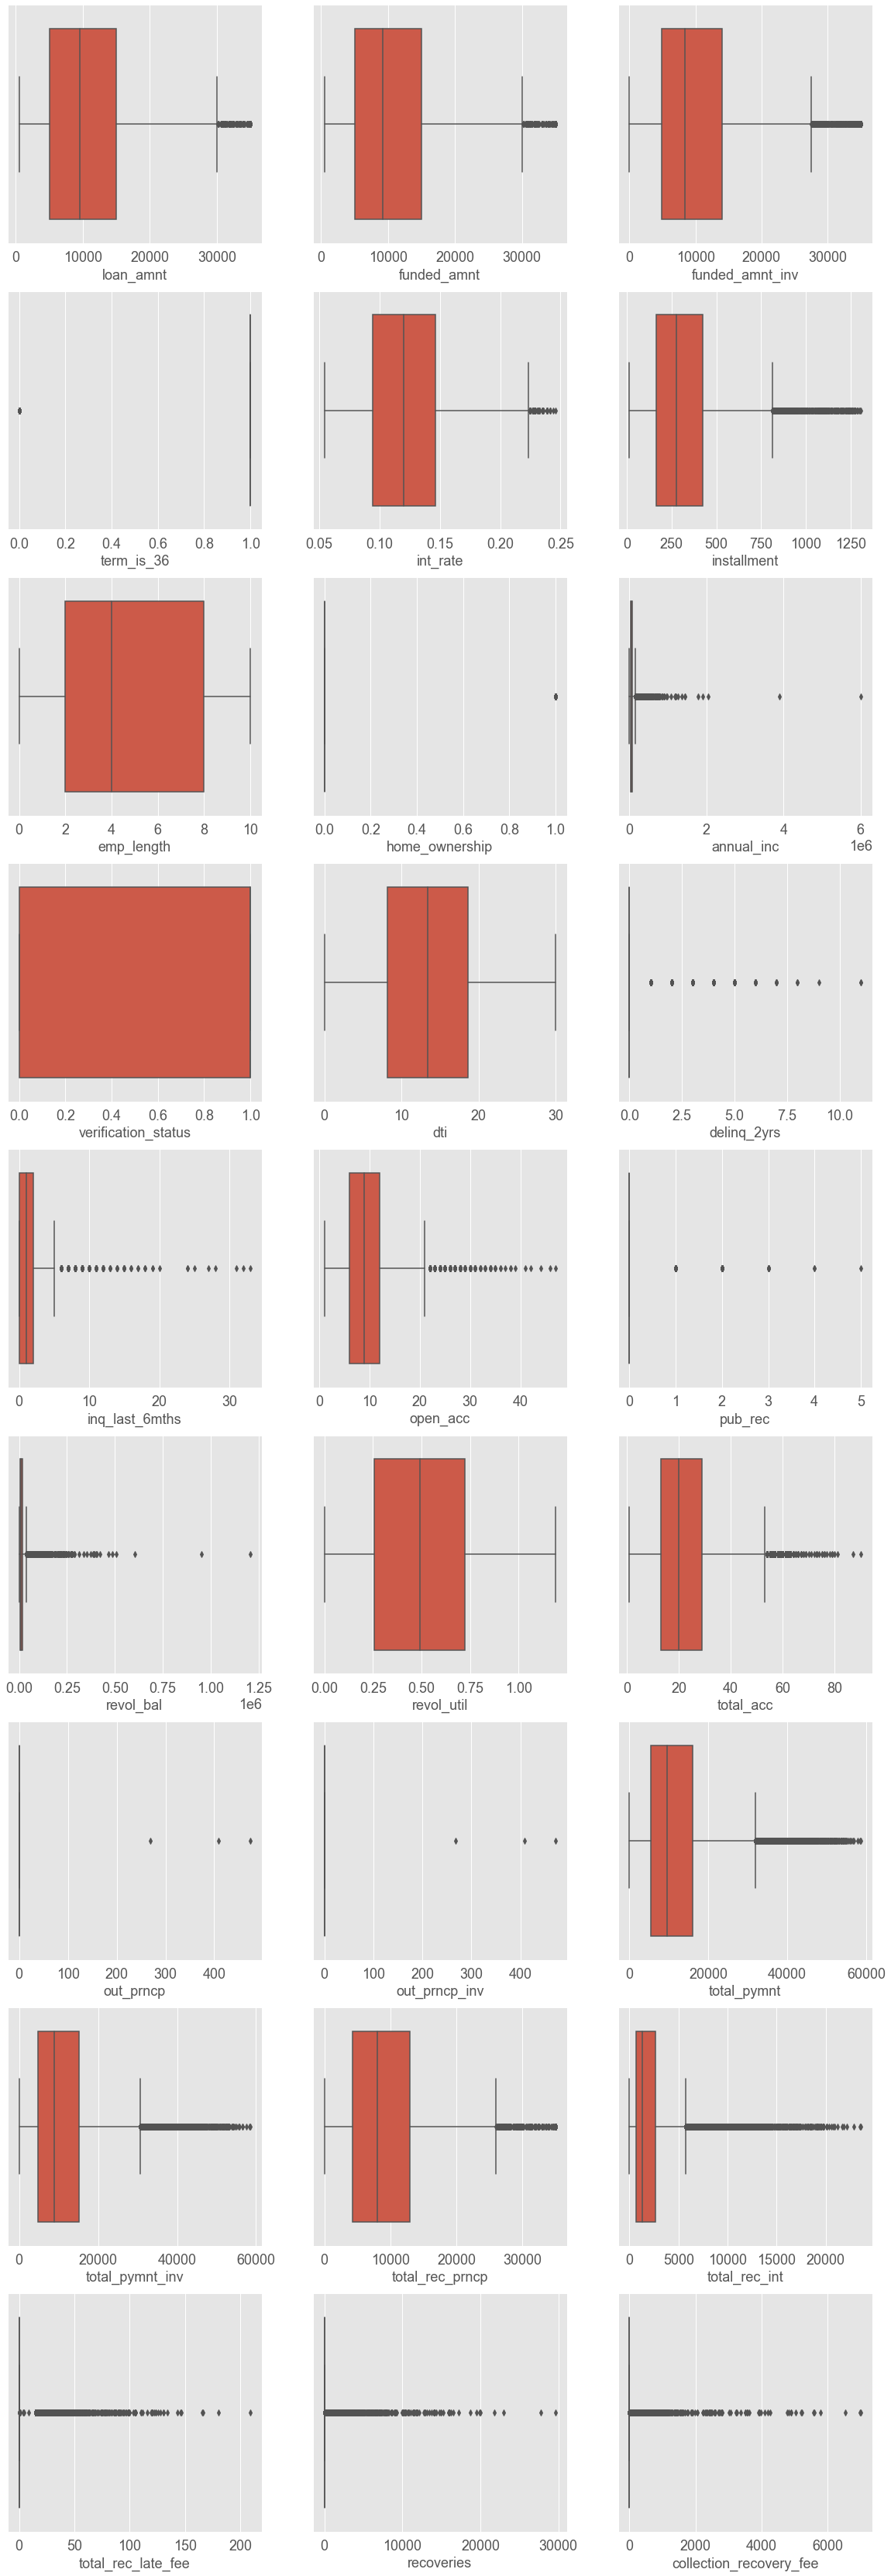

In [186]:
continuous_var = list(df_insp.select_dtypes(['int64','float64']))
# create distplots
fig = plt.figure(figsize=(20,60))
i=1

for column in df_insp[continuous_var]:
    plt.subplot(9,3,i)
    sns.boxplot(df_insp[column])
    i += 1
plt.savefig('plots/boxplots_all_numeric.png',dpi=300,bbox_inches='tight')
plt.savefig('plots/boxplots_all_numeric.pdf',bbox_inches='tight')

Conclusions on the boxplots:
- a
    
    
There are outliers in the following features:
- a
- b
- c

## Histograms for all variables

Since we later must consider scaling of the feature, we will have a look on the distribution of the features.

In [187]:
continuous_var = list(df_insp.select_dtypes(['int64','float64']))
len(continuous_var)

30

ValueError: num must be 1 <= num <= 27, not 28

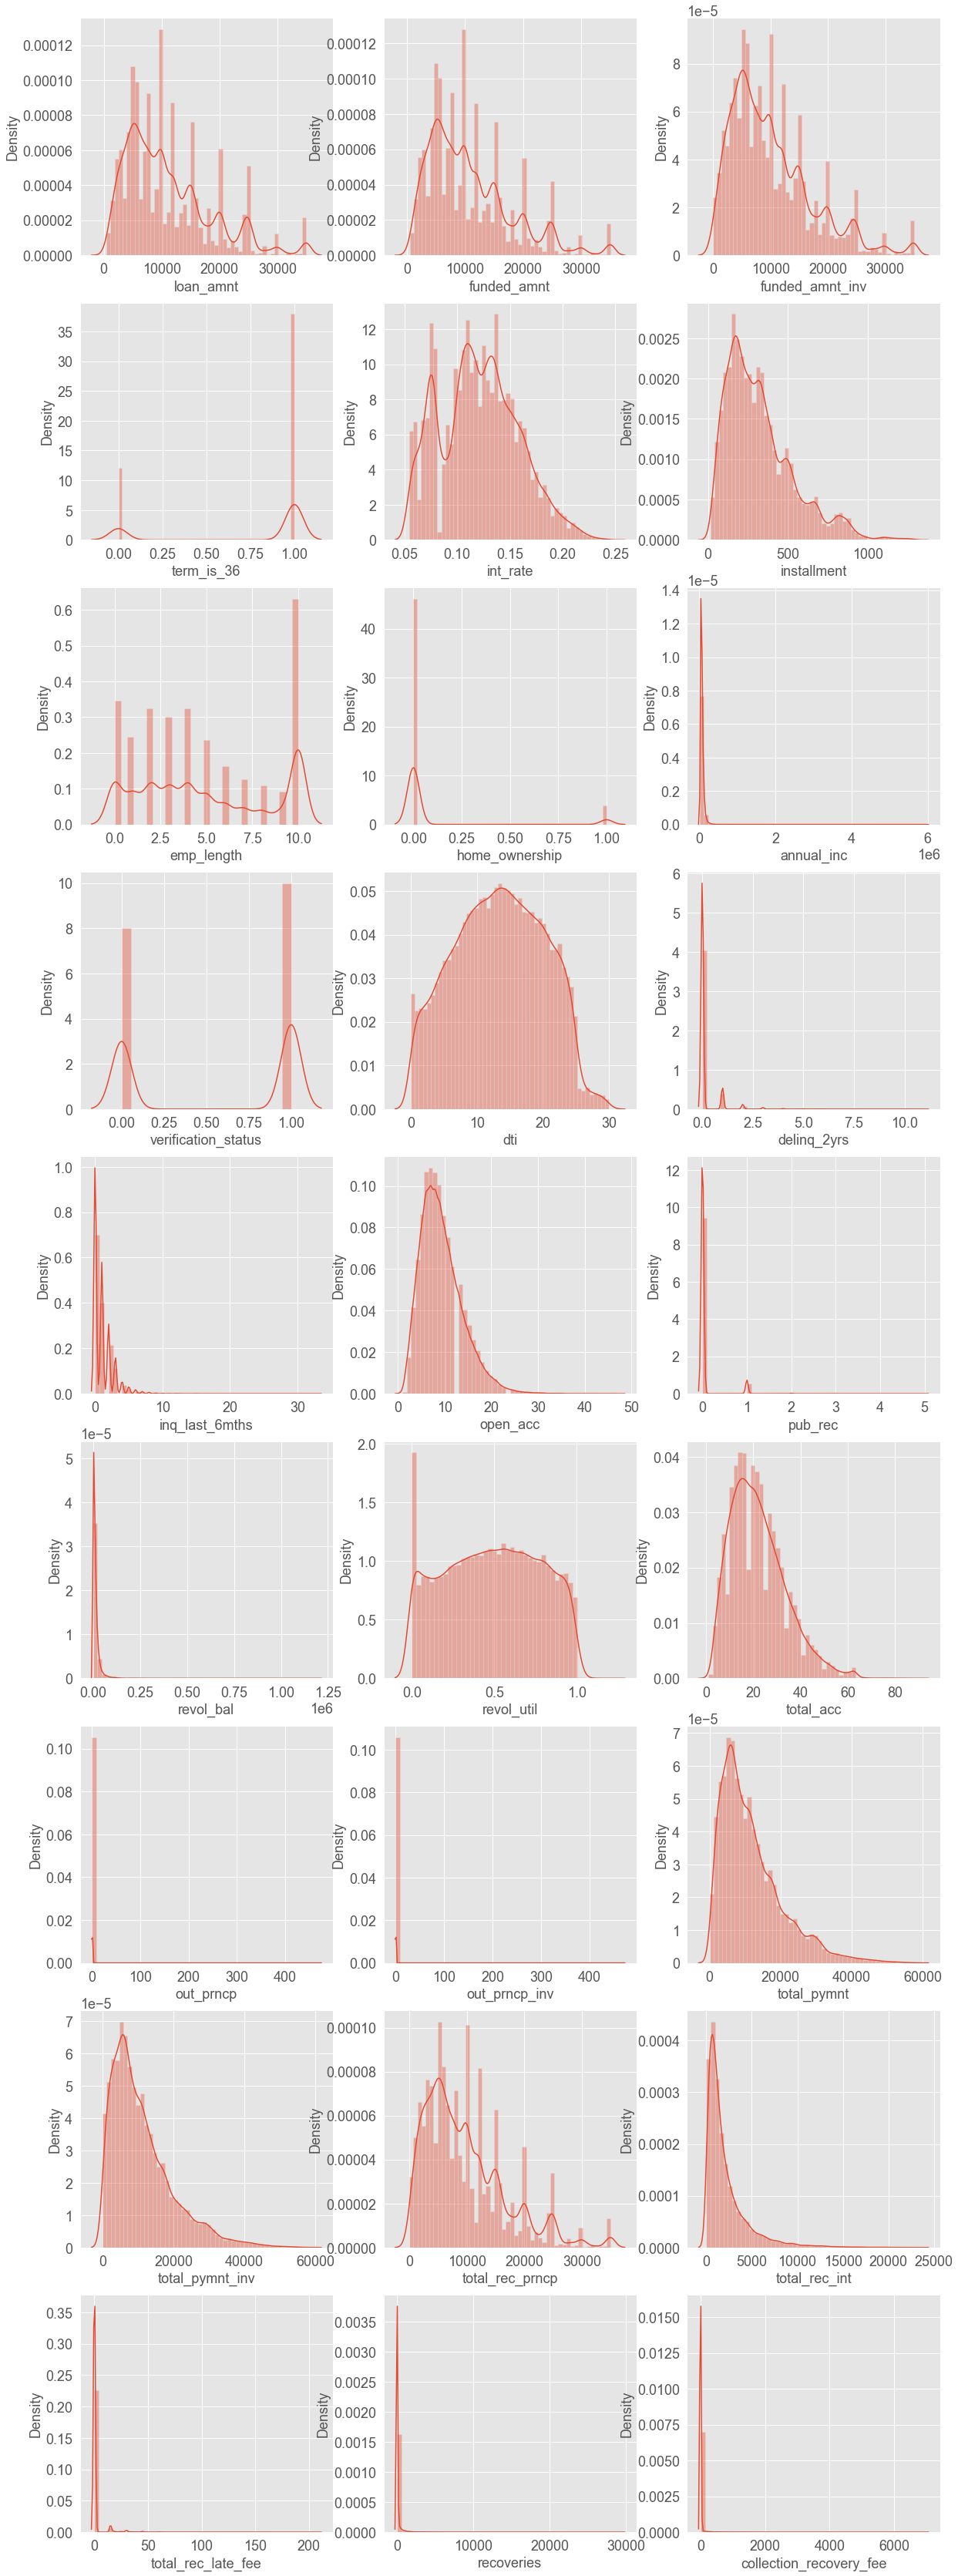

In [188]:
# create distplots
fig = plt.figure(figsize=(20,60))
i=1

for column in df_insp[continuous_var]:
    plt.subplot(9,3,i)
    sns.distplot(df_insp[column],hist=True)
    i += 1
plt.savefig('plots/histograms_all_numeric.png',dpi=300,bbox_inches='tight')
plt.savefig('plots/histograms_all_numeric.pdf',bbox_inches='tight')

Conclusions on the distributions:
- a
    
    
These features should be scaled:
- a
- b
- c

These featureses should be logaritmical:
    
- a
- b
- c

## Correlogram for continuous variables - Heatmap

Convert the default to numeric to have in included in the correlation heatmap. 

In [ ]:
df_insp.info()

In [189]:
continuous_var = list(df_insp.select_dtypes(['int64','float64']))
continuous_var              

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term_is_36',
 'int_rate',
 'installment',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'pub_rec_bankruptcies',
 'default']

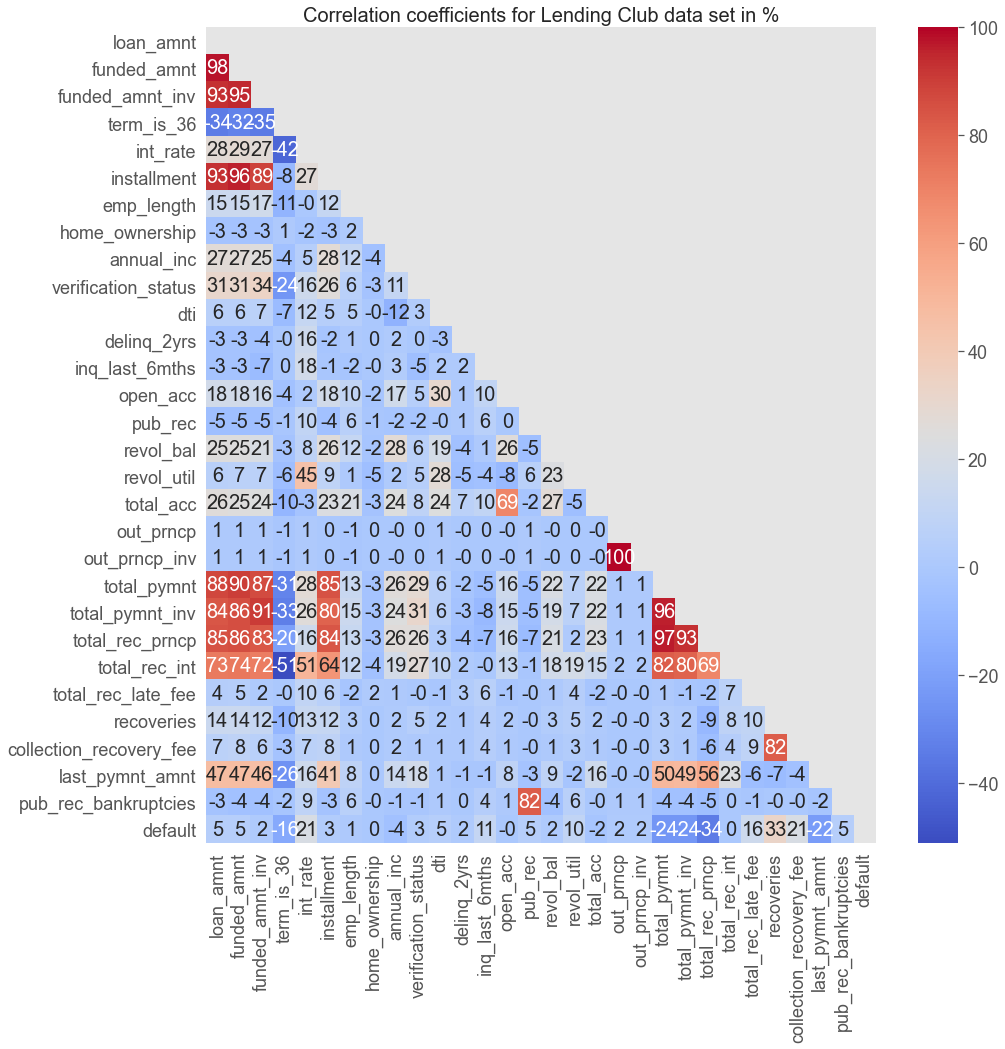

In [190]:
df_insp_cor=df_insp[continuous_var].copy()
mask = np.triu(df_insp_cor.corr())
fig, ax = plt.subplots(figsize=(15,15))  

sns.heatmap(round(df_insp_cor.corr()*100,0)
                 ,annot=True
                 ,mask=mask
                 ,cmap='coolwarm'
                 ,ax=ax
                 ,fmt='g')
#ax.set_ylim((0,15))
#ax.set_xlim((0,15))
plt.title('Correlation coefficients for Lending Club data set in %',size=20)
plt.savefig('plots/correlogram_heatmap.png')
plt.savefig('plots/correlogram_heatmap.pdf')

In [191]:
df_insp_cor.corr().round(2)

,loan_amnt,funded_amnt,funded_amnt_inv,term_is_36,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies,default
loan_amnt,1.00,0.98,0.93,-0.34,0.28,0.93,0.15,-0.03,0.27,0.31,0.06,-0.03,-0.03,0.18,-0.05,0.25,0.06,0.26,0.01,0.01,0.88,0.84,0.85,0.73,0.04,0.14,0.07,0.47,-0.03,0.05
funded_amnt,0.98,1.00,0.95,-0.32,0.29,0.96,0.15,-0.03,0.27,0.31,0.06,-0.03,-0.03,0.18,-0.05,0.25,0.07,0.25,0.01,0.01,0.90,0.86,0.86,0.74,0.05,0.14,0.08,0.47,-0.04,0.05
funded_amnt_inv,0.93,0.95,1.00,-0.35,0.27,0.89,0.17,-0.03,0.25,0.34,0.07,-0.04,-0.07,0.16,-0.05,0.21,0.07,0.24,0.01,0.01,0.87,0.91,0.83,0.72,0.02,0.12,0.06,0.46,-0.04,0.02
term_is_36,-0.34,-0.32,-0.35,1.00,-0.42,-0.08,-0.11,0.01,-0.04,-0.24,-0.07,-0.00,0.00,-0.04,-0.01,-0.03,-0.06,-0.10,-0.01,-0.01,-0.31,-0.33,-0.20,-0.51,-0.00,-0.10,-0.03,-0.26,-0.02,-0.16
int_rate,0.28,0.29,0.27,-0.42,1.00,0.27,-0.00,-0.02,0.05,0.16,0.12,0.16,0.18,0.02,0.10,0.08,0.45,-0.03,0.01,0.01,0.28,0.26,0.16,0.51,0.10,0.13,0.07,0.16,0.09,0.21
installment,0.93,0.96,0.89,-0.08,0.27,1.00,0.12,-0.03,0.28,0.26,0.05,-0.02,-0.01,0.18,-0.04,0.26,0.09,0.23,0.00,0.00,0.85,0.80,0.84,0.64,0.06,0.12,0.08,0.41,-0.03,0.03
emp_length,0.15,0.15,0.17,-0.11,-0.00,0.12,1.00,0.02,0.12,0.06,0.05,0.01,-0.02,0.10,0.06,0.12,0.01,0.21,-0.01,-0.01,0.13,0.15,0.13,0.12,-0.02,0.03,0.01,0.08,0.06,0.01
home_ownership,-0.03,-0.03,-0.03,0.01,-0.02,-0.03,0.02,1.00,-0.04,-0.03,-0.00,0.00,-0.00,-0.02,-0.01,-0.02,-0.05,-0.03,0.00,0.00,-0.03,-0.03,-0.03,-0.04,0.02,0.00,0.00,0.00,-0.00,0.00
annual_inc,0.27,0.27,0.25,-0.04,0.05,0.28,0.12,-0.04,1.00,0.11,-0.12,0.02,0.03,0.17,-0.02,0.28,0.02,0.24,-0.00,-0.00,0.26,0.24,0.26,0.19,0.01,0.02,0.02,0.14,-0.01,-0.04
verification_status,0.31,0.31,0.34,-0.24,0.16,0.26,0.06,-0.03,0.11,1.00,0.03,0.00,-0.05,0.05,-0.02,0.06,0.05,0.08,0.00,0.00,0.29,0.31,0.26,0.27,-0.00,0.05,0.01,0.18,-0.01,0.03


## Overal Skew and Kurtosis of the data

The skew gives us an idea of if the data is skewed to right or left. This might be usefull later for the normalization of the data. We can also consider the kurtosis of the data, which gives how close the distribution is to a normal distribution. 

In [192]:
statistics = pd.DataFrame(df_insp.describe())

In [193]:
skew = pd.Series(df_insp.skew())
kurtosis = pd.Series(df_insp.kurtosis())
statistics.loc['skew'] = skew
statistics.loc['kurtosis'] = kurtosis

In [194]:
statistics.T

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
loan_amnt,41292.0,10958.060278,7310.292251,500.0000,5000.000000,9600.0000,15000.000000,3.500000e+04,1.078220,0.843620
funded_amnt,41292.0,10696.472682,7053.977779,500.0000,5000.000000,9250.0000,15000.000000,3.500000e+04,1.100751,1.014122
funded_amnt_inv,41292.0,10016.784312,7021.795389,0.0000,4926.078869,8400.0000,13975.000000,3.500000e+04,1.123903,1.154601
term_is_36,41292.0,0.758549,0.427968,0.0000,1.000000,1.0000,1.000000,1.000000e+00,-1.208320,-0.539989
int_rate,41292.0,0.120931,0.036846,0.0542,0.094500,0.1197,0.146500,2.459000e-01,0.237159,-0.478758
installment,41292.0,321.206329,208.574618,15.6700,165.070000,276.0600,424.710000,1.305190e+03,1.143161,1.267214
emp_length,41292.0,4.880437,3.518619,0.0000,2.000000,4.0000,8.000000,1.000000e+01,0.247783,-1.308337
home_ownership,41292.0,0.076577,0.265922,0.0000,0.000000,0.0000,0.000000,1.000000e+00,3.184727,8.142882
annual_inc,41292.0,68992.600040,64488.545161,1896.0000,40000.000000,58500.0000,82000.000000,6.000000e+06,29.323089,2128.315220
verification_status,41292.0,0.555023,0.496969,0.0000,0.000000,1.0000,1.000000,1.000000e+00,-0.221444,-1.951057


## Final Feature Selection List and Dropping of Features

Now since we have an overvie of the remaining data and ist distribution, we can now drop some redundant columns:

We drop the almost identical features: 

- **"funded_amnt"** + "funded_amnt_inv": directly correlated to loan amount and are almost identical since the platform has some skin in the game and fills up to remaning amount, if the funded_amnt is not equal the total amount. 

- "installment": is directly correlated with loan amount, since the installment is calculated as a proportion of the loan amount per year ((loan_amount + interest)/(years*12)). 

- "home_ownership": We have found no influence, so we can skip it. 

- "verification_status": Can be dropped since the default rate is almost identical

- "delinq_2yrs": Almost all values are zero, is dropped. 

- "revol_bal", "revol_util": These features are related to revolving credits and therefore not relevant for fully paid or default credits.

-  "out_prnc","out_prncp_inv","total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries","collection_recovery_fee","last_pymnt_amnt": These values of the loan amount are related to current and late loans, since if a loan is a default or fully paid, we do not consider these values (such as recoveries, and oustanding payments). We drop all of this features. 

In [199]:
unnecessary_feature_list = ["funded_amnt","funded_amnt_inv","installment","home_ownership","verification_status","delinq_2yrs","revol_bal","revol_util","out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries","collection_recovery_fee","last_pymnt_amnt"]

In [200]:
df_insp.drop(unnecessary_feature_list, inplace=True, axis=1)

In [204]:
len(df_insp.columns)

16

In [205]:
df_insp.columns

Index(['loan_amnt', 'term_is_36', 'int_rate', 'grade', 'sub_grade',
       'emp_length', 'annual_inc', 'purpose', 'addr_state', 'dti',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc',
       'pub_rec_bankruptcies', 'default'],
      dtype='object')

## Export the dataframe to .csv file

In [206]:
df_insp.to_csv('data/df_clean.csv',sep=',')

# Feature Engineering

## Unemployment Rate (2007 to 2010)

# Predictive Modelling - Target: default

## Preprocessing (Train/Test Split)

In [ ]:
stratify by loan_status

### Train/test and preprocessing (full dataset)
### Train/test and preprocessing (reduced dataset)

## Single Machine Learning Methods
### Decision Tree
### Random Forest Classifier
### LogReg (with GridSearch)
### Support Vector Machine (SVM)
### AdaBoost
### XGBoost

## Combined Machine Learning Methods

## Optimization

# Data Visualization

## Findings and Recommendations
## Business Cases

# Future Work

# References